# Dataset loading

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [20]:
df = pd.read_csv("health_lifestyle_classification.csv")
# info about set
print(df.shape)
print("-----------")
df.head()

(100000, 48)
-----------


,survey_code,age,gender,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,...,sunlight_exposure,meals_per_day,caffeine_intake,family_history,pet_owner,electrolyte_level,gene_marker_flag,environmental_risk_score,daily_supplement_dosage,target
0,1,56,Male,173.416872,56.886640,18.915925,18.915925,56.747776,18.989117,72.165130,...,High,5,Moderate,No,Yes,0,1.0,5.5,-2.275502,healthy
1,2,69,Female,163.207380,97.799859,36.716278,36.716278,110.148833,36.511417,85.598889,...,High,5,High,Yes,No,0,1.0,5.5,6.239340,healthy
2,3,46,Male,177.281966,80.687562,25.673050,25.673050,77.019151,25.587429,90.295030,...,High,4,Moderate,No,No,0,1.0,5.5,5.423737,healthy
3,4,32,Female,172.101255,63.142868,21.318480,21.318480,63.955440,21.177109,100.504211,...,High,1,NaN,No,Yes,0,1.0,5.5,8.388611,healthy
4,5,60,Female,163.608816,40.000000,14.943302,14.943302,44.829907,14.844299,69.021150,...,High,1,High,Yes,Yes,0,1.0,5.5,0.332622,healthy


# Preprocessing

Data Preprocessing Tasks
- Data Cleaning: Fill in missing values, smooth noisy data, identify or remove outliers and noisy
data, and resolve inconsistencies
- Data transformation: Data normalization and aggregation
- Data reduction: Data reduction in volume but produces the same or similar analytical results
- Data discretization (for numerical data)

## Data Cleaning

### Missing and duplicate values

In [21]:
na = (df.isna().sum().to_frame("n_missing").assign(pct=lambda x: (100 * x["n_missing"] / len(df)).round(2)).sort_values(["pct", "n_missing"], ascending=False))

print("Duplicated (full-row):", df.duplicated().sum())
print("-----------------------")
print("\nTop-20 missingness:")
display(na.head(10))

Duplicated (full-row): 0
-----------------------

Top-20 missingness:


,n_missing,pct
alcohol_consumption,42387,42.39
caffeine_intake,33261,33.26
exercise_type,24969,24.97
insulin,15836,15.84
heart_rate,14003,14.00
gene_marker_flag,10474,10.47
income,8470,8.47
daily_steps,8329,8.33
blood_pressure,7669,7.67
survey_code,0,0.00


* Drop Alchol Consumption 42% missing

In [22]:
df = df.drop(columns='alcohol_consumption', errors="ignore")
df.shape[1]

47

* Exploring reminaing data types of missing data

In [23]:
# Unique categories and counts
for col in ["caffeine_intake", "exercise_type", "gene_marker_flag"]:
    print(f"\n=== {col} ===")
    print(df[col].value_counts(dropna=False).head(20))  # top 20 categories including NaN
    print("n_unique:", df[col].nunique(dropna=True))


=== caffeine_intake ===
caffeine_intake
Moderate    33371
High        33368
NaN         33261
Name: count, dtype: int64
n_unique: 2

=== exercise_type ===
exercise_type
Strength    25265
Cardio      24988
NaN         24969
Mixed       24778
Name: count, dtype: int64
n_unique: 3

=== gene_marker_flag ===
gene_marker_flag
1.0    89526
NaN    10474
Name: count, dtype: int64
n_unique: 1


* Filling with Unkown

In [24]:
df["caffeine_intake"] = df["caffeine_intake"].fillna("Unknown")
df["exercise_type"] = df["exercise_type"].fillna("None")


In [25]:
# Unique categories and counts
for col in ["caffeine_intake", "exercise_type"]:
    print(f"\n=== {col} ===")
    print(df[col].value_counts(dropna=False).head(20))  # top 20 categories including NaN
    print("n_unique:", df[col].nunique(dropna=True))


=== caffeine_intake ===
caffeine_intake
Moderate    33371
High        33368
Unknown     33261
Name: count, dtype: int64
n_unique: 3

=== exercise_type ===
exercise_type
Strength    25265
Cardio      24988
None        24969
Mixed       24778
Name: count, dtype: int64
n_unique: 4


* Gene marker flag

In [26]:
# df['gene_marker_flag'] = df['gene_marker_flag'].fillna(0) - doesnt make a signifciant difference
df["gene_marker_flag"].value_counts(dropna=False)

gene_marker_flag
1.0    89526
NaN    10474
Name: count, dtype: int64

In [27]:
df = df.drop(columns='gene_marker_flag', errors="ignore")
df.shape[1]

46

In [28]:
# Unique categories and counts
for col in ["caffeine_intake", "exercise_type"]:
    print(f"\n=== {col} ===")
    print(df[col].value_counts(dropna=False).head(20))  # top 20 categories including NaN
    print("n_unique:", df[col].nunique(dropna=True))


=== caffeine_intake ===
caffeine_intake
Moderate    33371
High        33368
Unknown     33261
Name: count, dtype: int64
n_unique: 3

=== exercise_type ===
exercise_type
Strength    25265
Cardio      24988
None        24969
Mixed       24778
Name: count, dtype: int64
n_unique: 4


* Drop income - beacuse it is unclear (anual etc)

In [29]:
df = df.drop(columns='income', errors="ignore")
df.shape[1]

45

* Learns a small regression model for each column with missing values, using the other columns as predictors, and iterates until convergence.

In [30]:
from sklearn.experimental import enable_iterative_imputer  # keep
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

num_cols_na = ["insulin","heart_rate","daily_steps","blood_pressure", ]

imp = IterativeImputer(
    estimator=BayesianRidge(),    
    max_iter=10,                  
    sample_posterior=False,       
    random_state=42
)

df[num_cols_na] = imp.fit_transform(df[num_cols_na])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.

#### Rechecking Missing values

In [31]:
na = (df.isna().sum().to_frame("n_missing").assign(pct=lambda x: (100 * x["n_missing"] / len(df)).round(2)).sort_values(["pct", "n_missing"], ascending=False))

print("Duplicated (full-row):", df.duplicated().sum())
print("-----------------------")
print("\nTop-20 missingness:")
display(na.head(10))

Duplicated (full-row): 0
-----------------------

Top-20 missingness:


,n_missing,pct
survey_code,0,0.0
age,0,0.0
gender,0,0.0
height,0,0.0
weight,0,0.0
bmi,0,0.0
bmi_estimated,0,0.0
bmi_scaled,0,0.0
bmi_corrected,0,0.0
waist_size,0,0.0


### EDA

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   survey_code               100000 non-null  int64  
 1   age                       100000 non-null  int64  
 2   gender                    100000 non-null  object 
 3   height                    100000 non-null  float64
 4   weight                    100000 non-null  float64
 5   bmi                       100000 non-null  float64
 6   bmi_estimated             100000 non-null  float64
 7   bmi_scaled                100000 non-null  float64
 8   bmi_corrected             100000 non-null  float64
 9   waist_size                100000 non-null  float64
 10  blood_pressure            100000 non-null  float64
 11  heart_rate                100000 non-null  float64
 12  cholesterol               100000 non-null  float64
 13  glucose                   100000 non-null  fl

Dropping unrelated and repeated colmuns

In [33]:
df[['bmi','bmi_estimated','bmi_scaled','bmi_corrected']].sample(5)

,bmi,bmi_estimated,bmi_scaled,bmi_corrected
69107,19.902776,19.902776,59.708327,19.867391
61362,22.683994,22.683994,68.051982,22.631121
88728,11.880641,11.880641,35.641922,12.185450
69070,25.017107,25.017107,75.051322,25.056080
44489,24.760401,24.760401,74.281204,24.231165


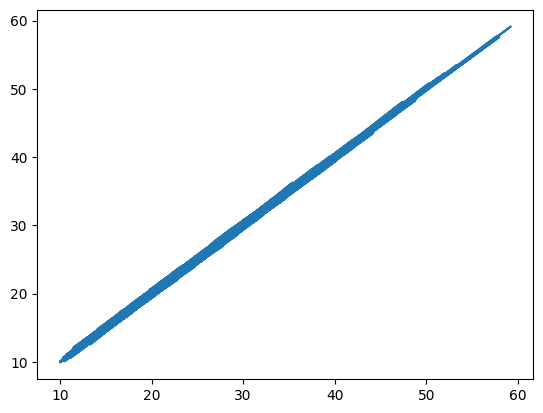

In [34]:
plt.plot(df['bmi'],df['bmi_corrected'])

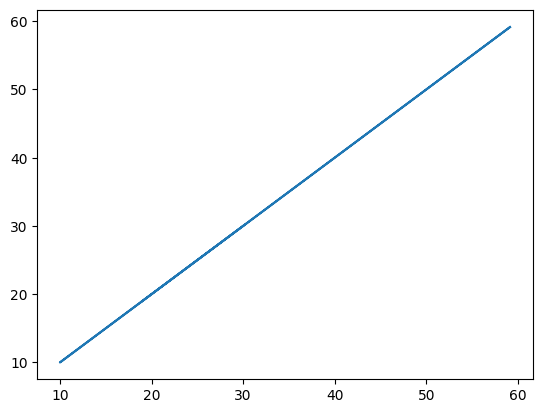

In [35]:
plt.plot(df['bmi'],df['bmi_estimated'])

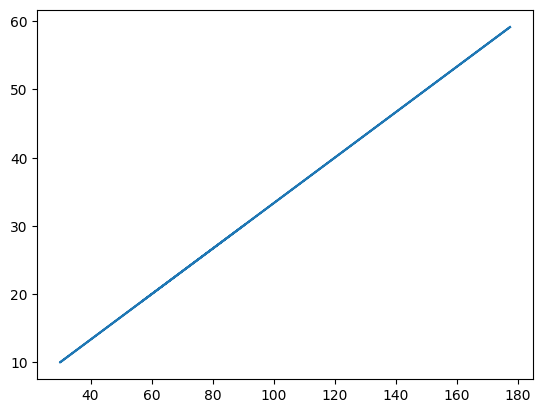

In [36]:
plt.plot(df['bmi_scaled'],df['bmi'])

In [37]:
df_drop = ['survey_code', 'bmi_scaled', 'bmi_scaled', 'bmi_corrected',  'bmi_estimated'] # also dropping survey_code of form
df = df.drop(columns=df_drop, errors="ignore")
print(df.shape[1])

41


In [38]:
import re
# --- 1) Show categories + counts ---
for col in ["occupation", "job_type"]:
    if col not in df.columns:
        raise KeyError(f"Missing column: {col}")
    # ensure categorical for tidy display (optional)
    df[col] = df[col].astype("category")
    print(f"\n[{col}] unique categories ({df[col].nunique()}):")
    display(df[col].value_counts().rename("count"))

# --- 2) Correspondence between occupation and job_type ---
ct_counts = pd.crosstab(df["occupation"], df["job_type"])
ct_rowpct = (ct_counts.div(ct_counts.sum(axis=1), axis=0).round(3) * 100)

print("\nCrosstab: counts")
display(ct_counts)

print("\nCrosstab: row-wise % (how each occupation maps to job_type)")
display(ct_rowpct)

# Random spot-check of pairs
print("\nRandom sample of occupation ↔ job_type pairs:")
display(df[["occupation", "job_type"]].sample(20, random_state=42))

# Optional: flag rows that don’t match the most common job_type for their occupation
dominant_job_for_occ = ct_counts.idxmax(axis=1)  # most frequent job_type per occupation
mismatch_mask = df["job_type"] != df["occupation"].map(dominant_job_for_occ)
print("\nExamples of 'mismatch' vs dominant mapping (first 20):")
display(df.loc[mismatch_mask, ["occupation", "job_type"]].head(20))


[occupation] unique categories (6):


occupation
Doctor      16927
Farmer      16719
Teacher     16661
Artist      16657
Driver      16562
Engineer    16474
Name: count, dtype: int64


[job_type] unique categories (6):


job_type
Labor         16777
Unemployed    16711
Office        16704
Tech          16691
Service       16571
Healthcare    16546
Name: count, dtype: int64


Crosstab: counts


job_type,Healthcare,Labor,Office,Service,Tech,Unemployed
occupation,,,,,,
Artist,2688,2801,2857,2730,2784,2797
Doctor,2834,2818,2826,2842,2785,2822
Driver,2707,2714,2843,2772,2796,2730
Engineer,2744,2780,2754,2712,2740,2744
Farmer,2802,2882,2692,2753,2798,2792
Teacher,2771,2782,2732,2762,2788,2826



Crosstab: row-wise % (how each occupation maps to job_type)


job_type,Healthcare,Labor,Office,Service,Tech,Unemployed
occupation,,,,,,
Artist,16.1,16.8,17.2,16.4,16.7,16.8
Doctor,16.7,16.6,16.7,16.8,16.5,16.7
Driver,16.3,16.4,17.2,16.7,16.9,16.5
Engineer,16.7,16.9,16.7,16.5,16.6,16.7
Farmer,16.8,17.2,16.1,16.5,16.7,16.7
Teacher,16.6,16.7,16.4,16.6,16.7,17.0



Random sample of occupation ↔ job_type pairs:


,occupation,job_type
75721,Teacher,Unemployed
80184,Driver,Unemployed
19864,Farmer,Healthcare
76699,Doctor,Unemployed
92991,Teacher,Healthcare
76434,Driver,Healthcare
84004,Teacher,Service
80917,Teacher,Labor
60767,Teacher,Labor
50074,Engineer,Tech



Examples of 'mismatch' vs dominant mapping (first 20):


,occupation,job_type
0,Farmer,Tech
1,Engineer,Office
2,Teacher,Office
3,Teacher,Labor
4,Doctor,Unemployed
5,Teacher,Office
6,Engineer,Unemployed
7,Farmer,Tech
8,Engineer,Office
9,Driver,Labor


In [39]:
df_drop = ['occupation'] 
df = df.drop(columns=df_drop, errors="ignore")
print(df.shape[1])

40


Check dimensions, datatypes, and target distribution.

#### Dataset Overview

In [40]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes.value_counts())
print("\nTarget distribution:\n", df["target"].value_counts(normalize=True))

Shape: (100000, 40)

Data Types:
 float64     19
object      15
int64        5
category     1
Name: count, dtype: int64

Target distribution:
 target
healthy     0.70097
diseased    0.29903
Name: proportion, dtype: float64


#### Categorical Variables

Exploring the categorical features frequency counts and visualize:

In [41]:
cat_cols = df.select_dtypes(include="object").columns.tolist()
print("Categorical columns:", cat_cols)

for col in cat_cols:
    print(f"\n=== {col} ===")
    print(df[col].value_counts(dropna=False).head(10))

Categorical columns: ['gender', 'sleep_quality', 'smoking_level', 'mental_health_support', 'education_level', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'insurance', 'sunlight_exposure', 'caffeine_intake', 'family_history', 'pet_owner', 'target']

=== gender ===
gender
Male      50132
Female    49868
Name: count, dtype: int64

=== sleep_quality ===
sleep_quality
Good         25147
Excellent    25091
Fair         25008
Poor         24754
Name: count, dtype: int64

=== smoking_level ===
smoking_level
Light         33437
Non-smoker    33355
Heavy         33208
Name: count, dtype: int64

=== mental_health_support ===
mental_health_support
No     50104
Yes    49896
Name: count, dtype: int64

=== education_level ===
education_level
Bachelor       25363
High School    25028
Master         24992
PhD            24617
Name: count, dtype: int64

=== diet_type ===
diet_type
Vegan         25122
Omnivore      25089
Vegetarian    25025
Keto          24764
Name: count, dtype: i

Visualization (barplots for top categories):

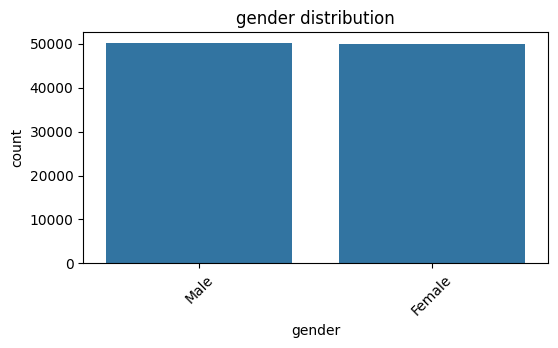

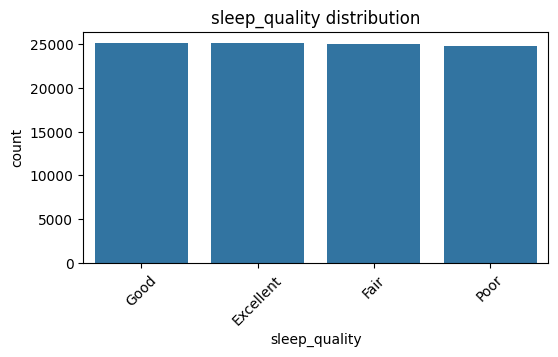

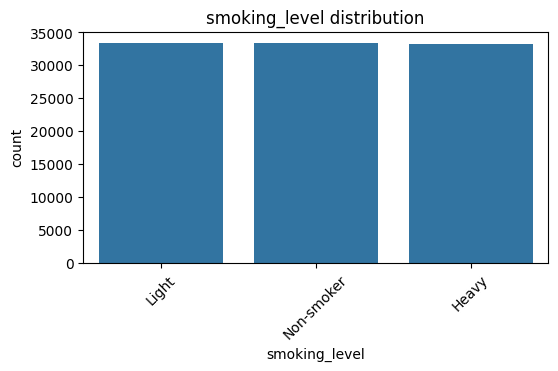

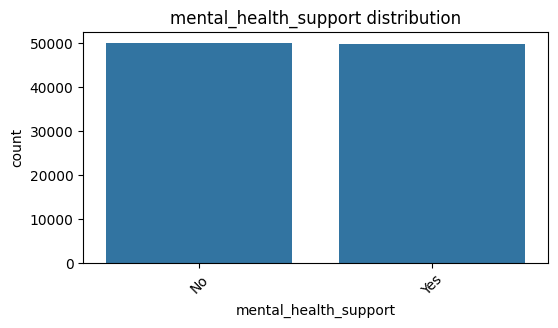

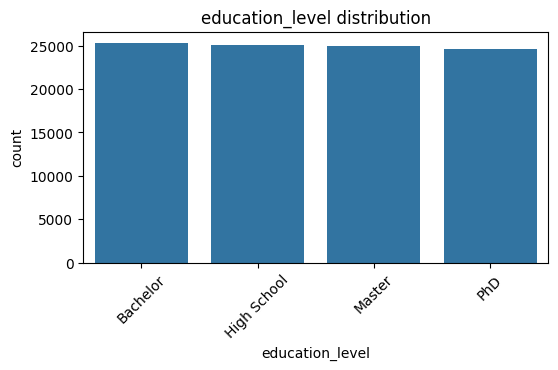

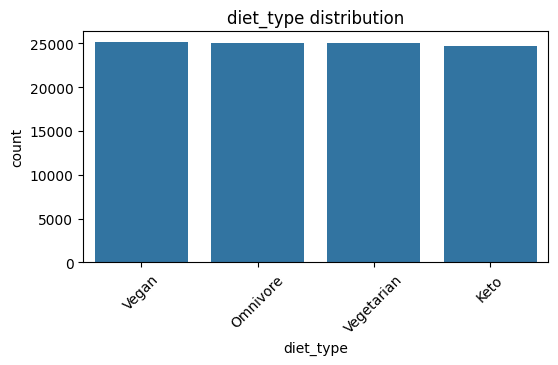

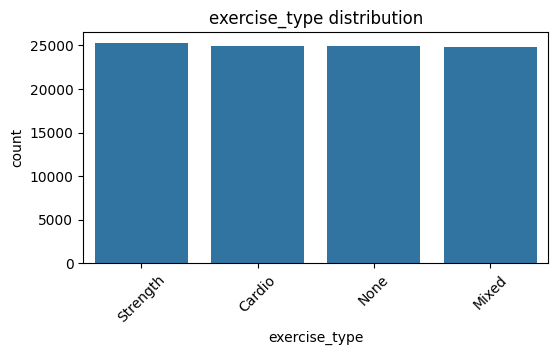

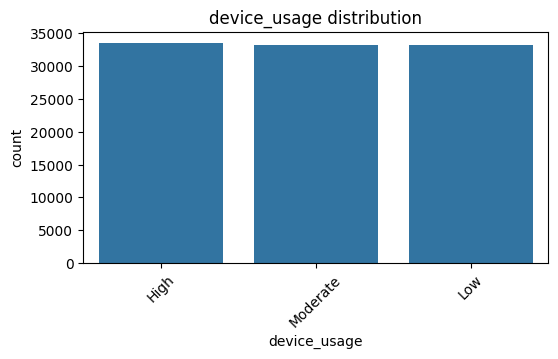

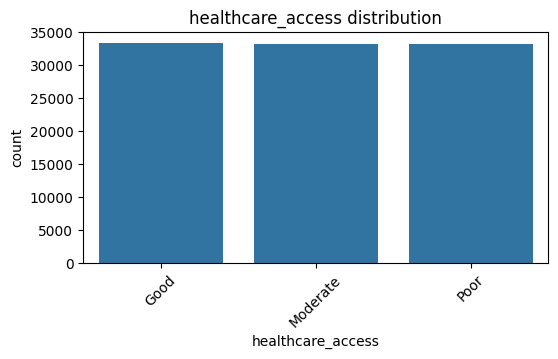

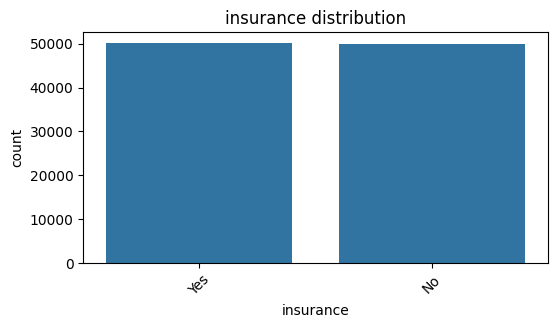

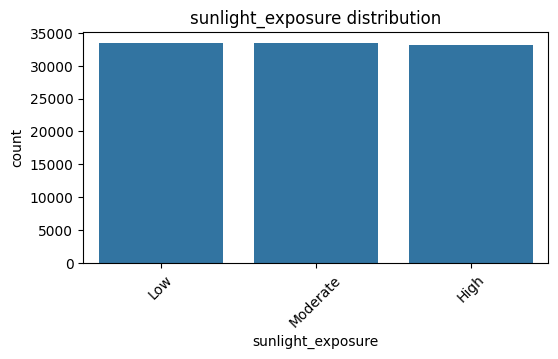

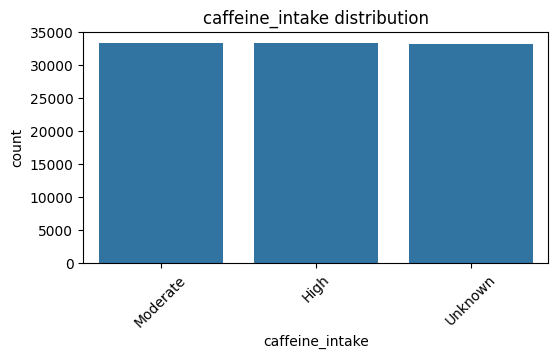

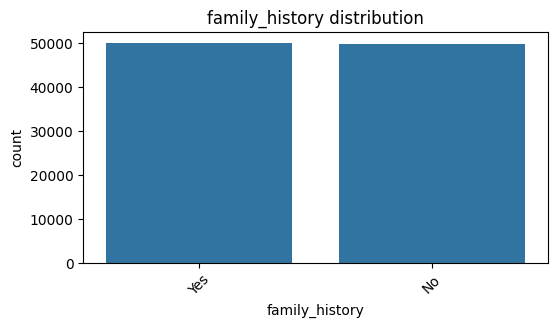

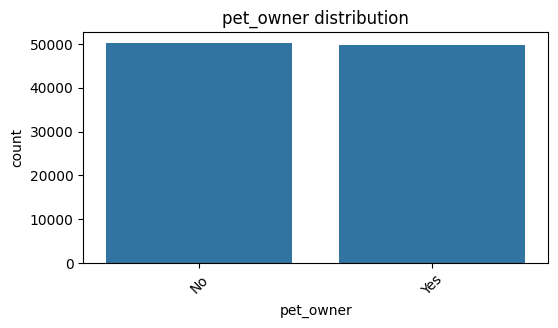

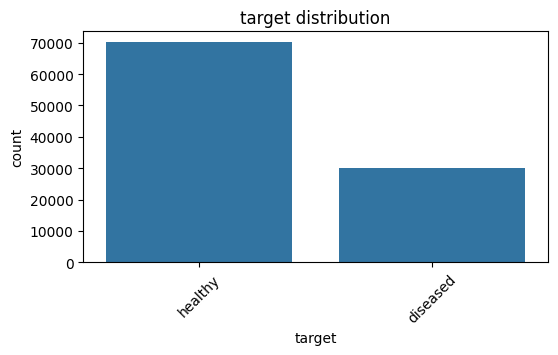

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"{col} distribution")
    plt.xticks(rotation=45)
    plt.show()

#### Numerical Variables

Explore distributions, central tendency, and outliers:

Numerical columns: ['age', 'height', 'weight', 'bmi', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'meals_per_day', 'electrolyte_level', 'environmental_risk_score', 'daily_supplement_dosage']


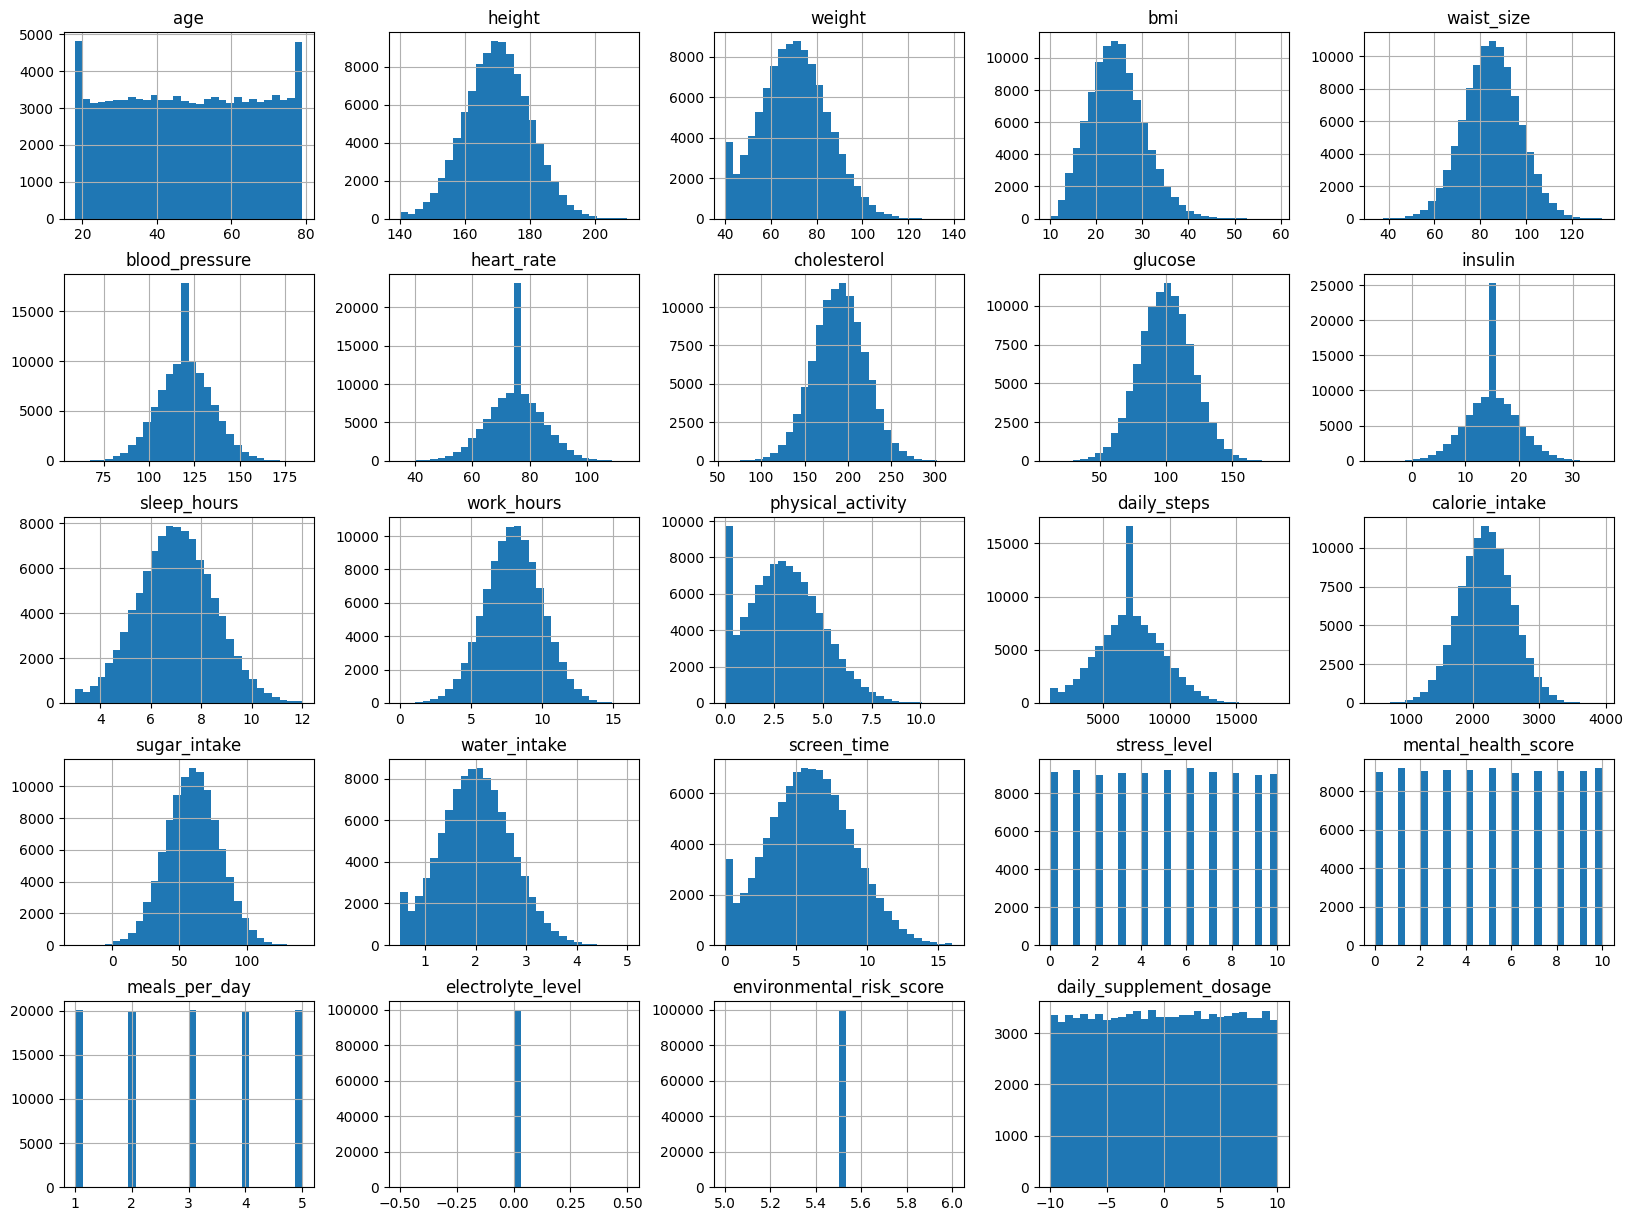

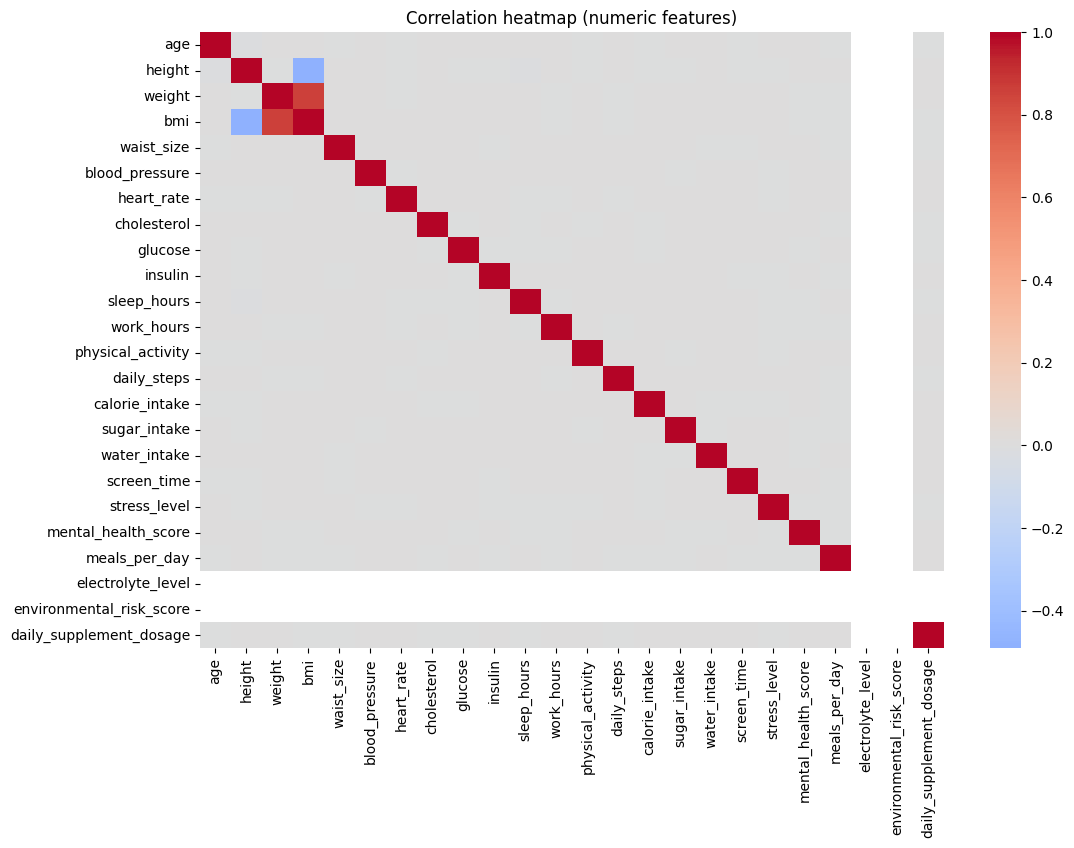

In [43]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
print("Numerical columns:", num_cols)

# Summary statistics
df[num_cols].describe().T

# Histograms
df[num_cols].hist(bins=30, figsize=(20,15))
plt.show()

# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()

Dropping unnecessary cols

In [44]:
df_drop_2 = ['survey_code','environmental_risk_score', 'electrolyte_level']
df = df.drop(columns=df_drop_2, errors="ignore")
print(df.shape[1])
print(df.columns)

38
Index(['age', 'gender', 'height', 'weight', 'bmi', 'waist_size',
       'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin',
       'sleep_hours', 'sleep_quality', 'work_hours', 'physical_activity',
       'daily_steps', 'calorie_intake', 'sugar_intake', 'smoking_level',
       'water_intake', 'screen_time', 'stress_level', 'mental_health_score',
       'mental_health_support', 'education_level', 'job_type', 'diet_type',
       'exercise_type', 'device_usage', 'healthcare_access', 'insurance',
       'sunlight_exposure', 'meals_per_day', 'caffeine_intake',
       'family_history', 'pet_owner', 'daily_supplement_dosage', 'target'],
      dtype='object')


rechecking

Numerical columns: ['age', 'height', 'weight', 'bmi', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'meals_per_day', 'daily_supplement_dosage']


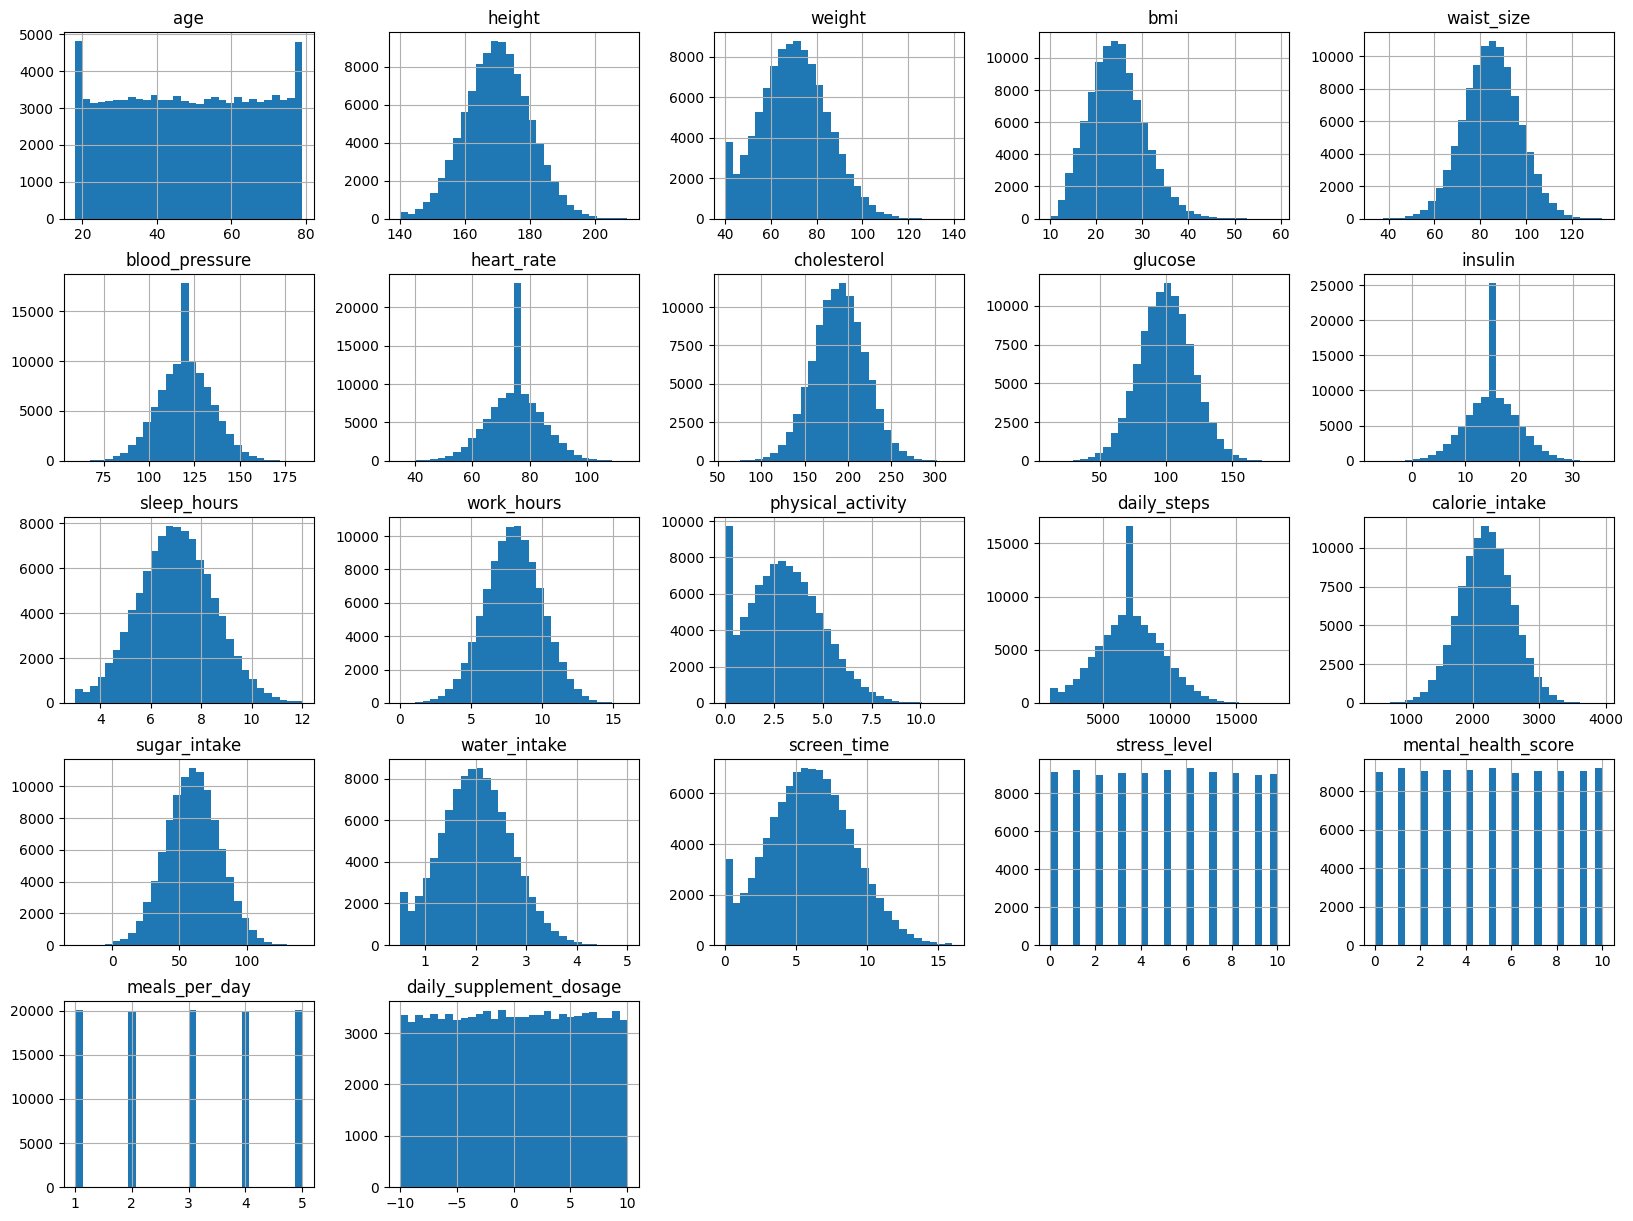

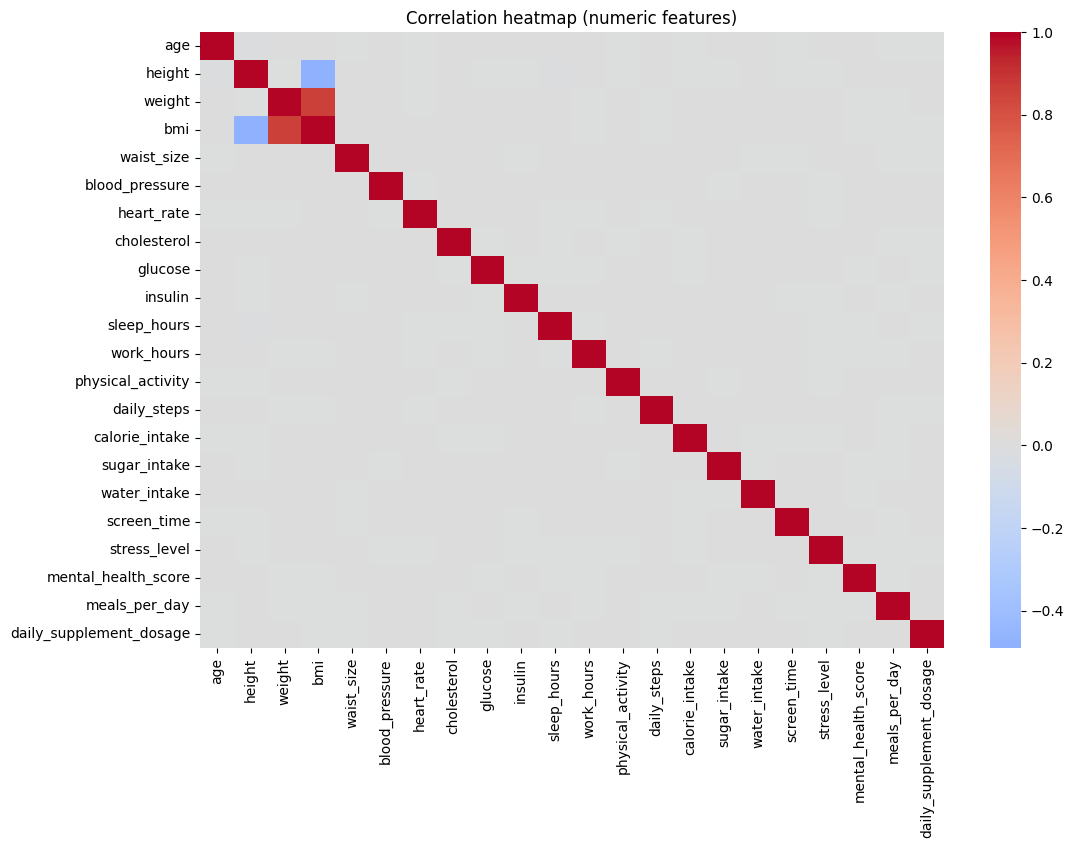

In [45]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
print("Numerical columns:", num_cols)

# Summary statistics
df[num_cols].describe().T

# Histograms
df[num_cols].hist(bins=30, figsize=(20,15))
plt.show()

# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.show()

### Feature vs Target Relationships

#### Categorical vs Target

In [46]:
for col in cat_cols:
    ct = pd.crosstab(df[col], df["target"], normalize="index")
    print(f"\n{col} vs target:\n", ct)


gender vs target:
 target  diseased   healthy
gender                    
Female  0.299451  0.700549
Male    0.298612  0.701388

sleep_quality vs target:
 target         diseased   healthy
sleep_quality                    
Excellent      0.298673  0.701327
Fair           0.299144  0.700856
Good           0.295264  0.704736
Poor           0.303103  0.696897

smoking_level vs target:
 target         diseased   healthy
smoking_level                    
Heavy          0.300741  0.699259
Light          0.297395  0.702605
Non-smoker     0.298966  0.701034

mental_health_support vs target:
 target                 diseased   healthy
mental_health_support                    
No                     0.299796  0.700204
Yes                    0.298260  0.701740

education_level vs target:
 target           diseased   healthy
education_level                    
Bachelor         0.296337  0.703663
High School      0.300863  0.699137
Master           0.300376  0.699624
PhD              0.298574  0.701

In [47]:
import pandas as pd

focus_table = []

for col in cat_cols:
    ct = pd.crosstab(df[col], df["target"], normalize="index")
    if "diseased" in ct.columns:   # safety check
        ct["diff"] = ct["diseased"] - ct["diseased"].mean()
        focus_table.append((col, ct["diff"].abs().max()))

focus_df = pd.DataFrame(focus_table, columns=["Feature", "MaxDifference"]).sort_values("MaxDifference", ascending=False)
print(focus_df)

                  Feature  MaxDifference
14                 target       0.500000
6           exercise_type       0.004435
1           sleep_quality       0.004057
5               diet_type       0.002702
4         education_level       0.002700
11        caffeine_intake       0.002554
8       healthcare_access       0.002486
2           smoking_level       0.001707
7            device_usage       0.001388
3   mental_health_support       0.000768
0                  gender       0.000419
9               insurance       0.000414
10      sunlight_exposure       0.000295
12         family_history       0.000061
13              pet_owner       0.000045


**Categories vs Target Plots**

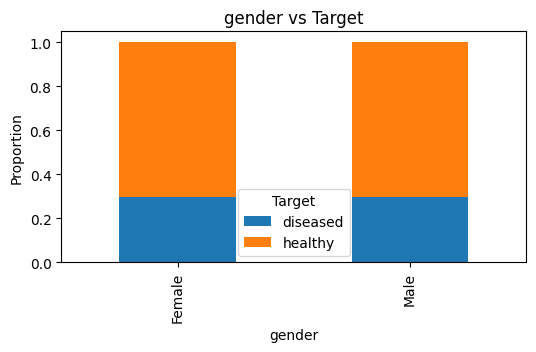

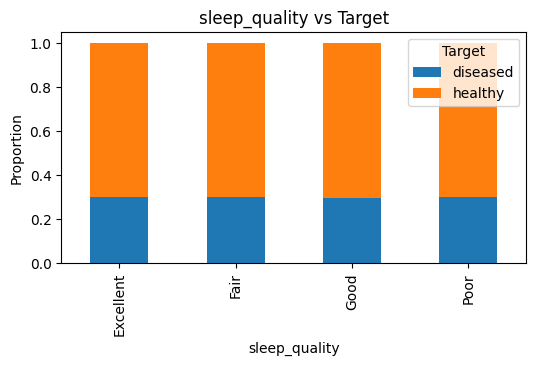

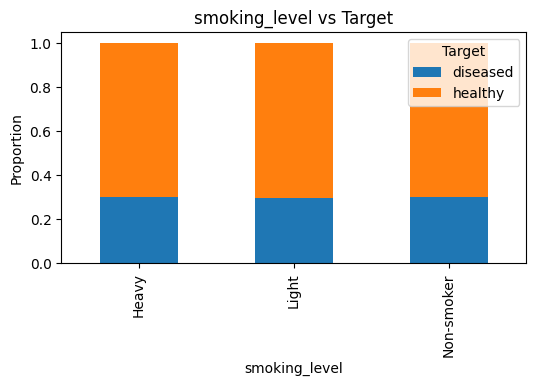

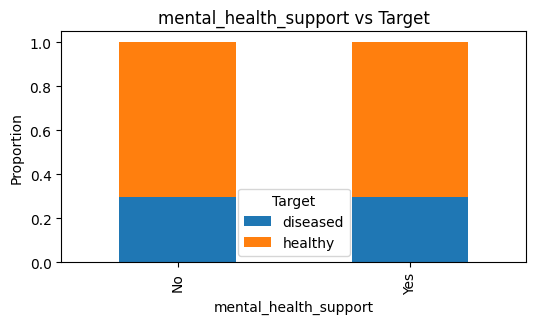

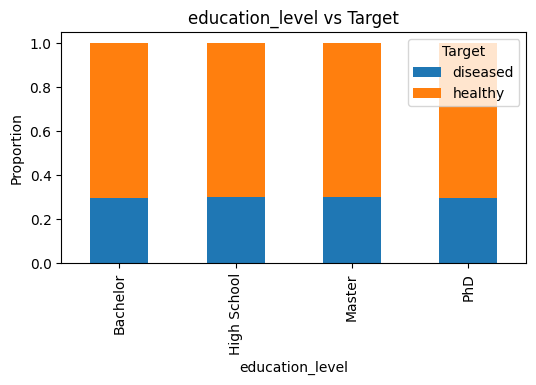

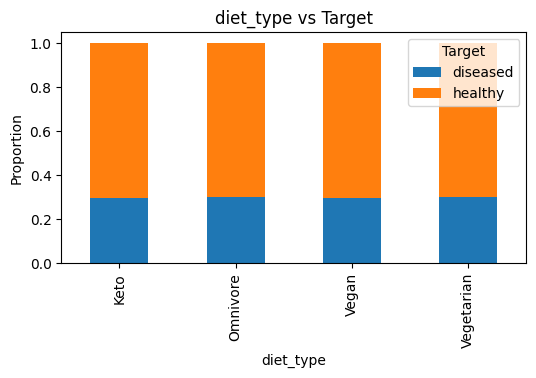

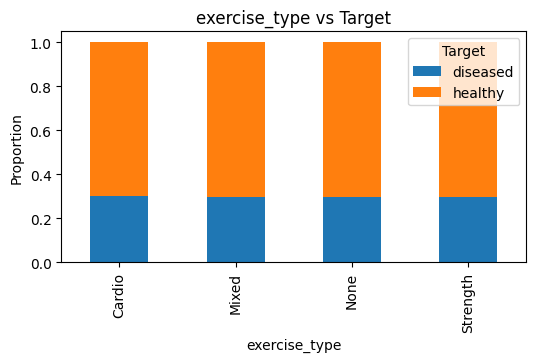

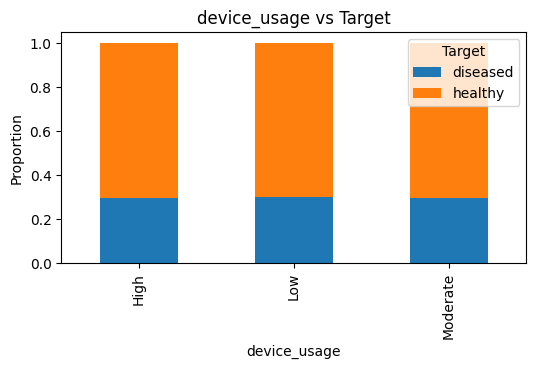

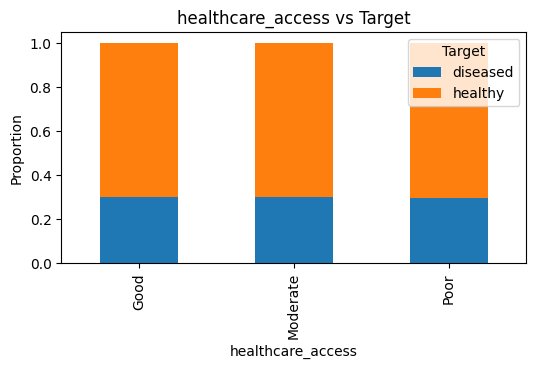

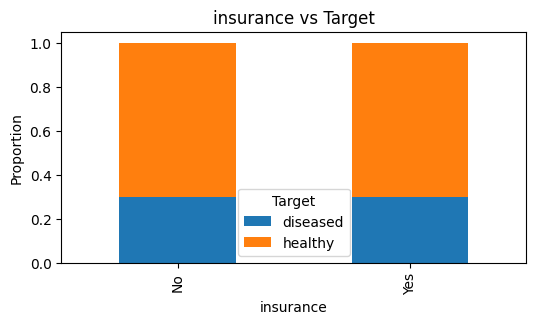

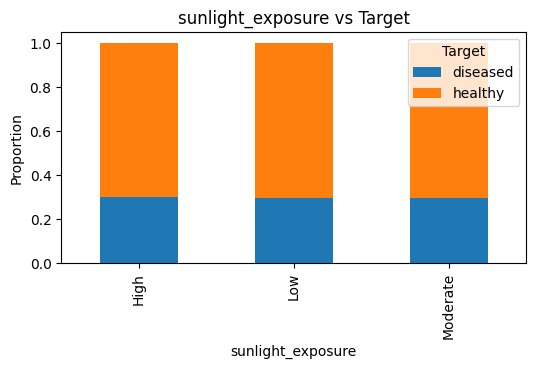

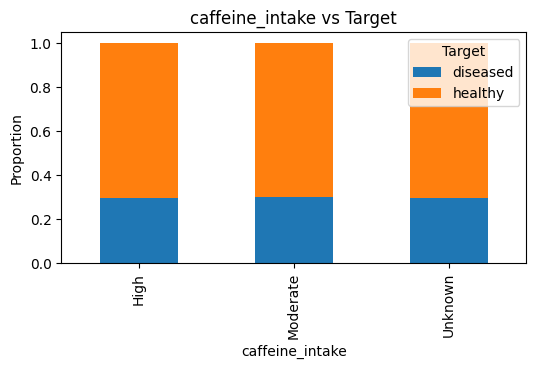

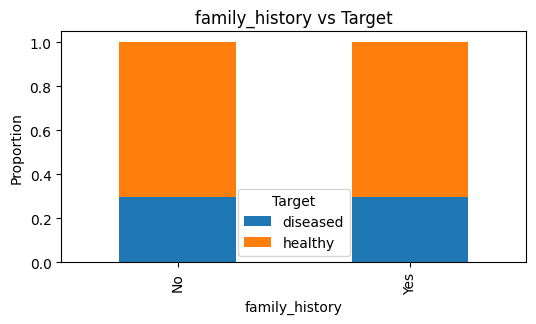

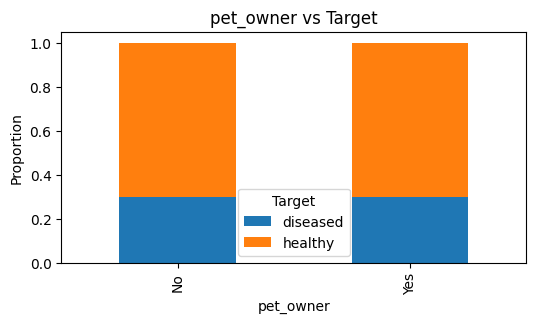

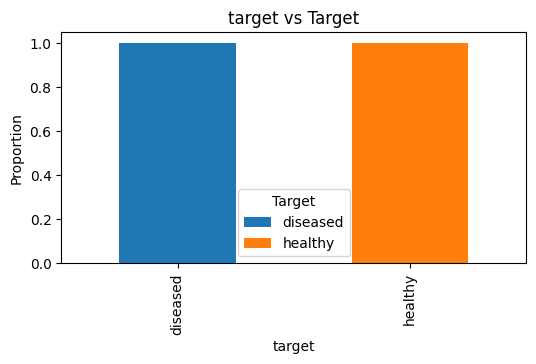

In [48]:
import matplotlib.pyplot as plt

for col in cat_cols:
    ct = pd.crosstab(df[col], df["target"], normalize="index")
    ct.plot(kind="bar", stacked=True, figsize=(6,3))
    plt.title(f"{col} vs Target")
    plt.ylabel("Proportion")
    plt.legend(title="Target")
    plt.show()

Categorical features in the dataset are generally weak predictors individually (max diffs <0.0005).

In [49]:
# Threshold for weak categorical features
threshold = 0.0005

# Get features below threshold
drop_cols_3 = focus_df.loc[focus_df["MaxDifference"] < threshold, "Feature"].tolist()

print("Categorical columns to drop (MaxDifference < 0.0005):")
print(drop_cols_3)

Categorical columns to drop (MaxDifference < 0.0005):
['gender', 'insurance', 'sunlight_exposure', 'family_history', 'pet_owner']


In [50]:
df = df.drop(columns=drop_cols_3, errors="ignore")
print(df.shape[1])
print(df.columns)

33
Index(['age', 'height', 'weight', 'bmi', 'waist_size', 'blood_pressure',
       'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours',
       'sleep_quality', 'work_hours', 'physical_activity', 'daily_steps',
       'calorie_intake', 'sugar_intake', 'smoking_level', 'water_intake',
       'screen_time', 'stress_level', 'mental_health_score',
       'mental_health_support', 'education_level', 'job_type', 'diet_type',
       'exercise_type', 'device_usage', 'healthcare_access', 'meals_per_day',
       'caffeine_intake', 'daily_supplement_dosage', 'target'],
      dtype='object')


#### Numerical vs Target (boxplots)

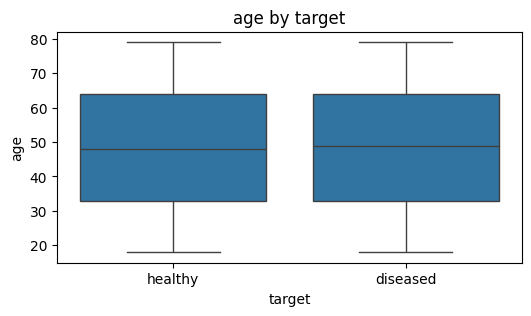

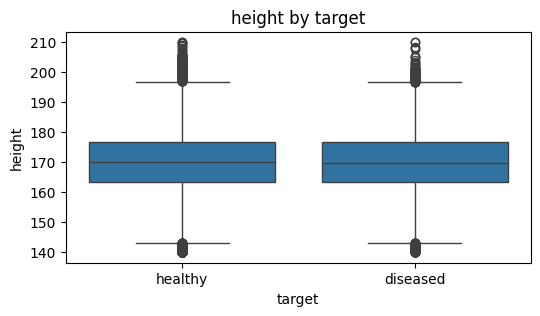

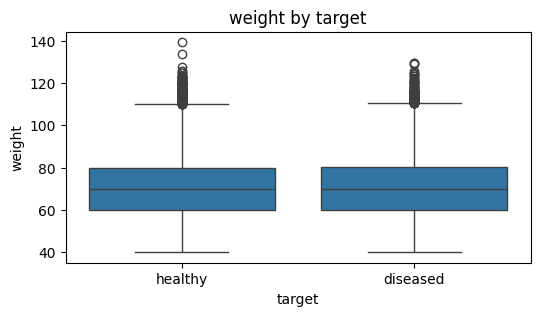

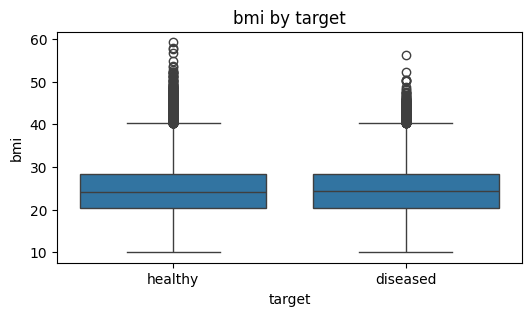

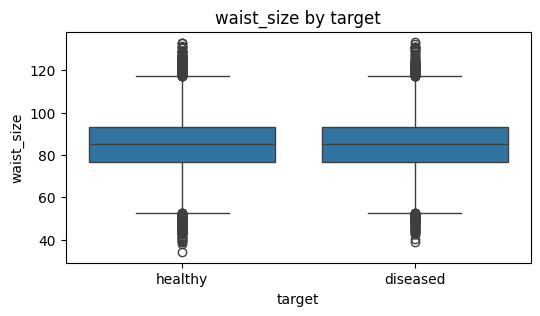

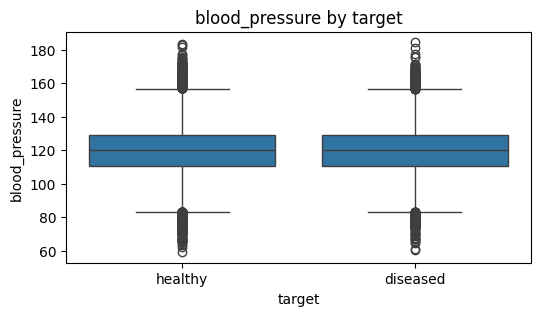

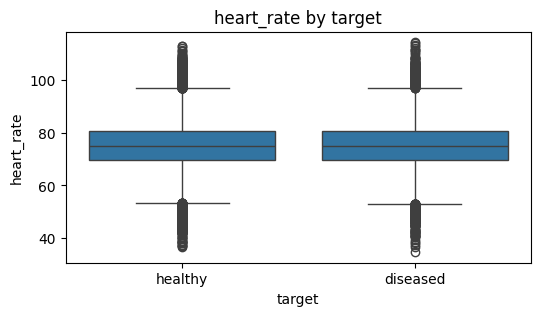

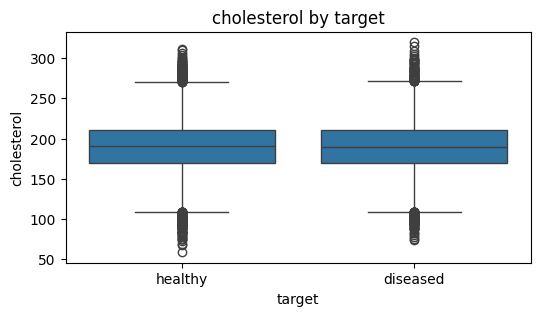

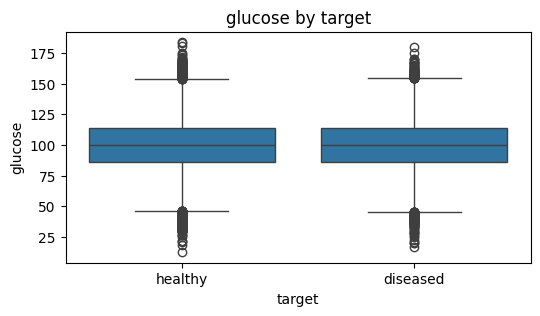

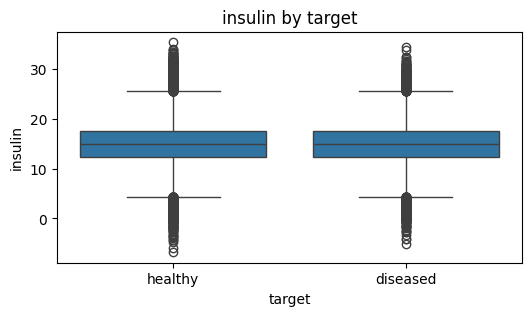

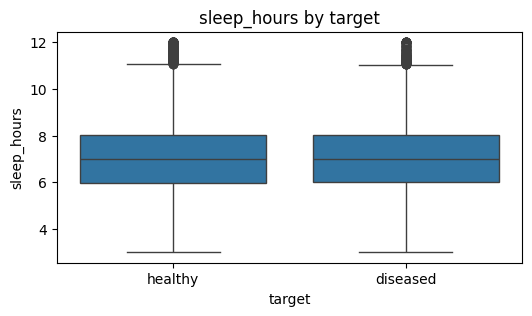

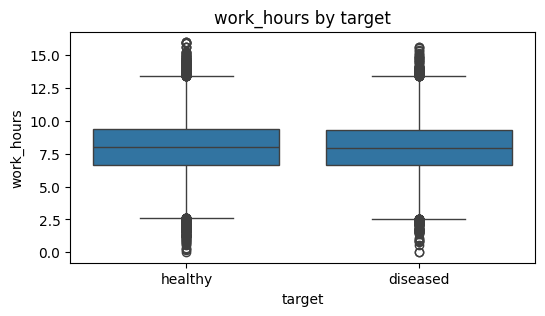

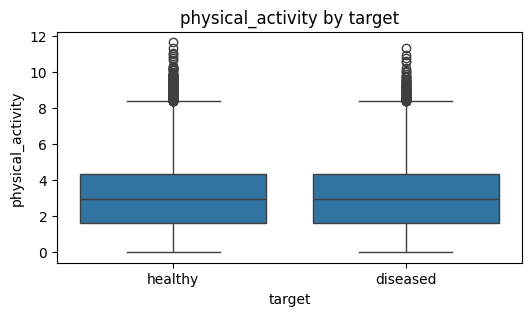

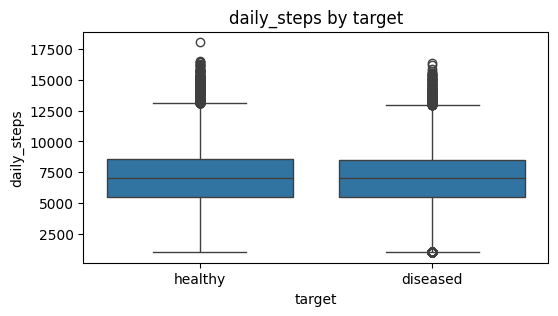

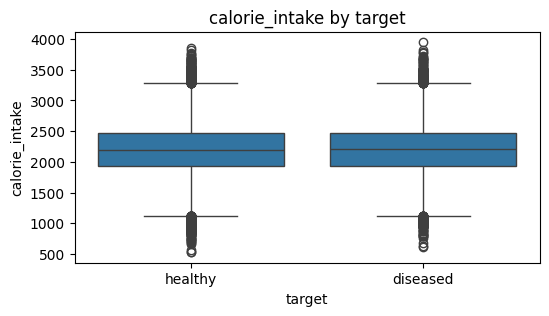

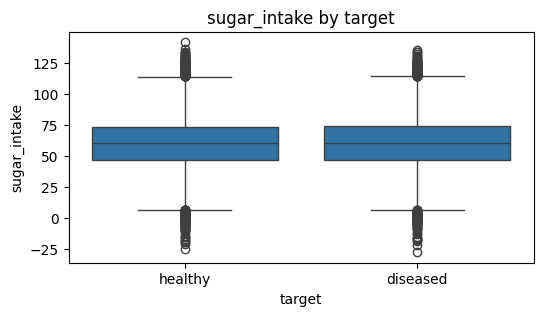

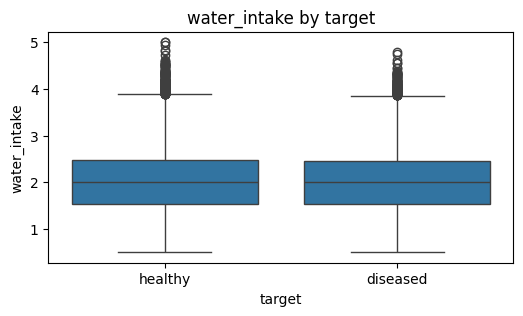

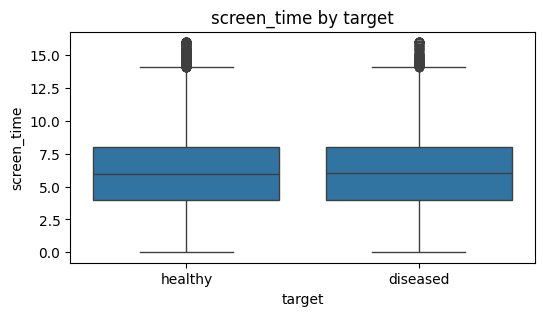

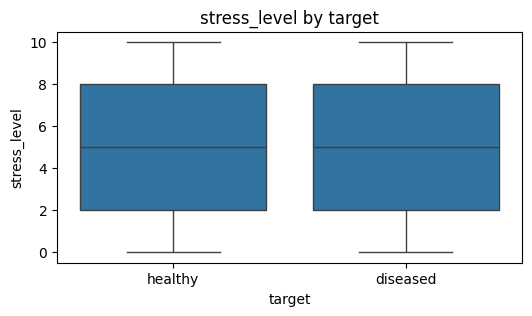

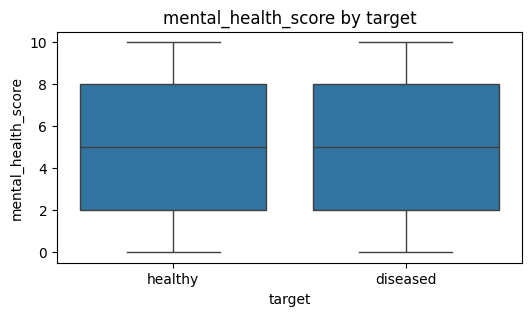

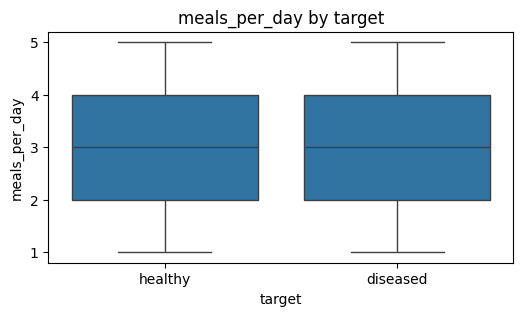

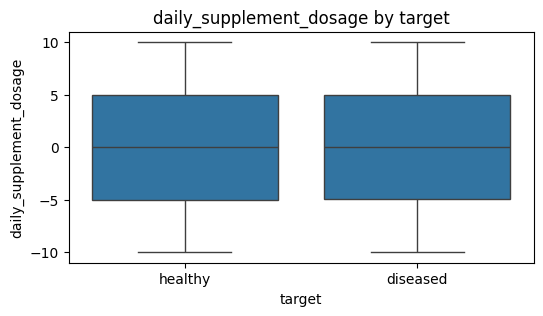

In [51]:
for col in num_cols:
    if col != "target": 
        plt.figure(figsize=(6,3))
        sns.boxplot(x="target", y=col, data=df)
        plt.title(f"{col} by target")
        plt.show()

* Pval intpret
	*	High effect size + low p-value = strong, meaningful predictor.
	*	Low effect size + low p-value = “significant but trivial” (large sample sizes can make even tiny differences statistically significant).
	*	High effect size + high p-value = might be meaningful but not enough data (rare here with 100k rows).
	*	Low effect size + high p-value = useless predictor (drop candidate).

In [52]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Select only numeric columns (no need to drop target since it's not numeric)
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()

results = []

for col in num_cols:
    diseased = df.loc[df["target"]=="diseased", col].dropna()
    healthy  = df.loc[df["target"]=="healthy", col].dropna()
    
    # Means
    mean_d = diseased.mean()
    mean_h = healthy.mean()
    
    # Cohen's d (effect size)
    pooled_std = np.sqrt(((diseased.std()**2) + (healthy.std()**2)) / 2)
    effect_size = (mean_d - mean_h) / pooled_std if pooled_std > 0 else 0
    
    # T-Test p-value
    _, pval = ttest_ind(diseased, healthy, equal_var=False, nan_policy="omit")
    
    results.append((col, mean_d, mean_h, effect_size, pval))

num_focus = pd.DataFrame(results, 
                         columns=["Feature","Mean_diseased","Mean_healthy","EffectSize","p_value"]) \
            .sort_values("EffectSize", key=np.abs, ascending=False)

print(num_focus.head(15))

                Feature  Mean_diseased  Mean_healthy  EffectSize   p_value
11           work_hours       7.968023      8.015540   -0.023816  0.000567
0                   age      48.716350     48.444784    0.015183  0.027944
13          daily_steps    6995.284519   7020.450973   -0.010569  0.125700
20        meals_per_day       2.992409      3.001412   -0.006365  0.356721
2                weight      70.123936     70.039661    0.005734  0.406517
5        blood_pressure     119.924110    120.004052   -0.005540  0.422565
3                   bmi      24.516903     24.484052    0.005526  0.423241
16         water_intake       2.004424      2.007204   -0.004037  0.558691
10          sleep_hours       7.005818      7.000383    0.003634  0.598631
7           cholesterol     190.036612    189.936502    0.003337  0.629142
1                height     170.001501    170.033180   -0.003177  0.645058
19  mental_health_score       5.011270      5.001869    0.002970  0.667347
12    physical_activity  

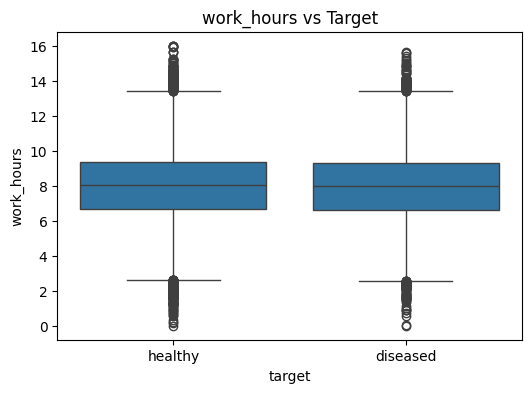

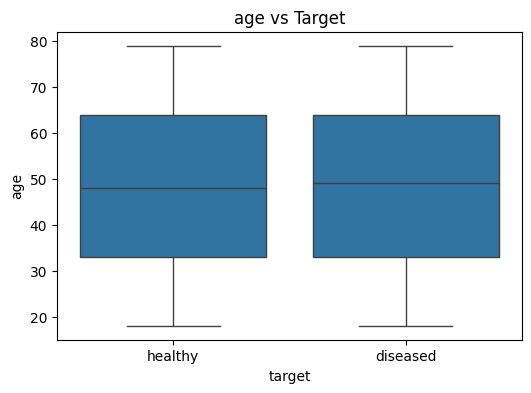

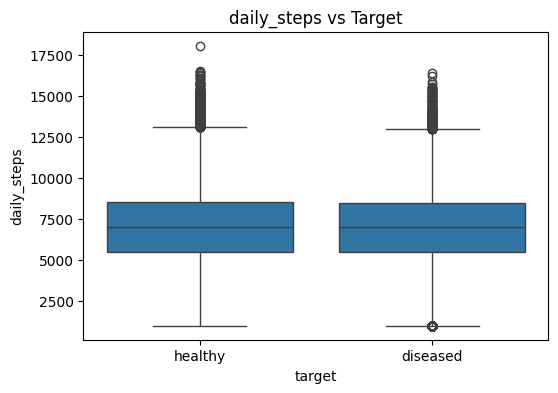

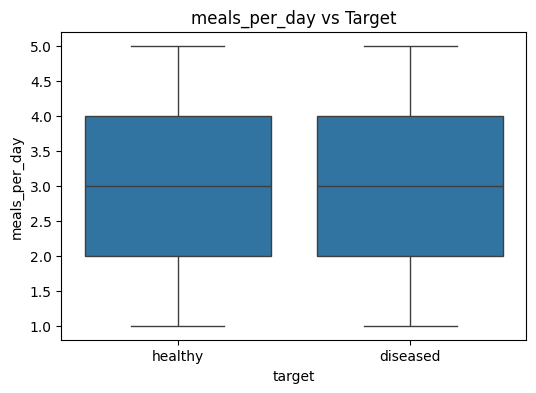

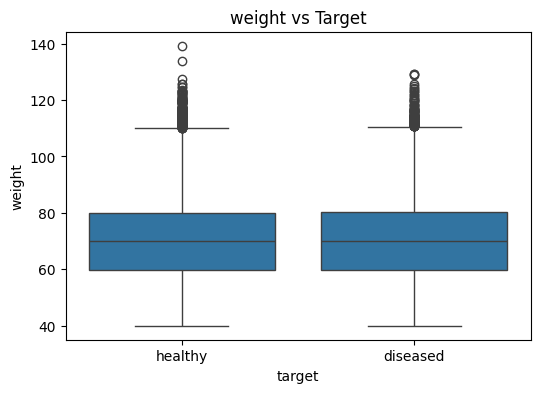

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

top_features = num_focus.head(5)["Feature"].tolist()

for col in top_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="target", y=col, data=df)
    plt.title(f"{col} vs Target")
    plt.show()

In [54]:
print(df.shape[1])
print(df.columns)

33
Index(['age', 'height', 'weight', 'bmi', 'waist_size', 'blood_pressure',
       'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours',
       'sleep_quality', 'work_hours', 'physical_activity', 'daily_steps',
       'calorie_intake', 'sugar_intake', 'smoking_level', 'water_intake',
       'screen_time', 'stress_level', 'mental_health_score',
       'mental_health_support', 'education_level', 'job_type', 'diet_type',
       'exercise_type', 'device_usage', 'healthcare_access', 'meals_per_day',
       'caffeine_intake', 'daily_supplement_dosage', 'target'],
      dtype='object')


### Skewness Checks

In [55]:
num_cols = [col for col in num_cols if col in df.columns]
from scipy.stats import skew

skewness = df[num_cols].apply(lambda x: skew(x.dropna()))
print("Skewness of numeric features:\n", skewness.sort_values(ascending=False))

Skewness of numeric features:
 bmi                        0.420699
physical_activity          0.307911
weight                     0.128873
screen_time                0.118884
water_intake               0.101683
daily_steps                0.054738
sleep_hours                0.025132
height                     0.008942
blood_pressure             0.003810
sugar_intake               0.002888
insulin                    0.002693
calorie_intake             0.001981
mental_health_score        0.001703
age                        0.001258
meals_per_day              0.000885
waist_size                 0.000200
stress_level              -0.000440
work_hours                -0.002391
daily_supplement_dosage   -0.004888
glucose                   -0.006844
cholesterol               -0.009801
heart_rate                -0.024226
dtype: float64


No extreme skewed variables (nothing > 1) - No urgent transformations needed

### Multicollinearity - Cross-feature contradictions

Check if some features are redundant:

In [56]:
import numpy as np

corr = df[num_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.85)]
print("Highly correlated features:", high_corr)

Highly correlated features: ['bmi']


Dropping height and weight as it highlt correlate to BMI

In [57]:
df_drop_5 = ['height', 'weight'] 
df = df.drop(columns=df_drop_5, errors="ignore")
print(df.shape[1])

31


In [58]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes.value_counts())
print("\nTarget distribution:\n", df["target"].value_counts(normalize=True))



Shape: (100000, 31)

Data Types:
 float64     16
object      10
int64        4
category     1
Name: count, dtype: int64

Target distribution:
 target
healthy     0.70097
diseased    0.29903
Name: proportion, dtype: float64


### Summary

In [59]:
cat_cols = [col for col in df.columns if df[col].dtype == "O"]
num_cols = [col for col in df.columns if df[col].dtype != "O" and col != "target"]
bool_cols = [col for col in df.columns if df[col].dtype == "bool"]

print("Category Cols DF", cat_cols)
print("Numerical Colms DF:", num_cols)

print("--------------")



Category Cols DF ['sleep_quality', 'smoking_level', 'mental_health_support', 'education_level', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'caffeine_intake', 'target']
Numerical Colms DF: ['age', 'bmi', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'job_type', 'meals_per_day', 'daily_supplement_dosage']
--------------


### Smoothing Nosiy Data and Outlier detection

In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,48.525990,17.886768,18.000000,33.000000,48.000000,64.000000,79.000000
bmi,100000.0,24.493876,5.951069,9.988495,20.271405,24.156734,28.258696,59.234792
waist_size,100000.0,84.933043,12.040314,34.093185,76.795185,84.957139,93.018713,133.153631
blood_pressure,100000.0,119.980147,14.428244,59.128168,110.815119,119.980033,129.185145,184.439195
heart_rate,100000.0,74.969335,9.219386,34.745092,69.543894,74.970922,80.467128,114.136041
cholesterol,100000.0,189.966438,29.981934,58.410902,169.667738,190.044579,210.222005,319.875613
glucose,100000.0,99.994538,19.982828,12.434931,86.461401,99.986834,113.508722,183.883548
insulin,100000.0,14.988280,4.589598,-6.794483,12.324714,14.988341,17.663430,35.464749
sleep_hours,100000.0,7.002008,1.496821,3.000000,5.986781,6.998164,8.019219,12.000000
work_hours,100000.0,8.001331,1.994723,0.000000,6.651093,8.004549,9.353669,16.000000


Outlier detection

In [61]:
from scipy.stats import zscore

def outlier_summary(df, z_thresh=3):
    """
    Detect outliers in numeric columns using IQR and Z-score methods.
    
    Parameters:
        df : pandas DataFrame
        z_thresh : float, threshold for Z-score (default=3)
    
    Returns:
        summary_df : DataFrame with counts and % of outliers for each method
    """
    
    num_cols = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in num_cols:
        series = df[col].dropna()

        # --- IQR Method ---
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        iqr_outliers = ((series < lower) | (series > upper)).sum()

        # --- Z-score Method ---
        z_scores = zscore(series)
        z_outliers = (np.abs(z_scores) > z_thresh).sum()

        # Save results
        results.append({
            "Feature": col,
            "IQR_outliers": iqr_outliers,
            "IQR_outlier_pct": round(100 * iqr_outliers / len(series), 2),
            "Z_outliers": z_outliers,
            "Z_outlier_pct": round(100 * z_outliers / len(series), 2),
        })

    return pd.DataFrame(results).sort_values("IQR_outlier_pct", ascending=False)


DF

In [62]:
summary = outlier_summary(df)
# print(summary)

# Filter out rows where IQR_outlier_pct is 0
non_zero_outliers = summary[summary['IQR_outlier_pct'] != 0]
# Print only Feature and IQR_outlier_pct
print(non_zero_outliers[['Feature', 'IQR_outlier_pct']].to_string(index=False))


          Feature  IQR_outlier_pct
          insulin             2.79
       heart_rate             2.45
   blood_pressure             1.33
              bmi             0.94
   calorie_intake             0.73
       waist_size             0.71
      daily_steps             0.71
     sugar_intake             0.69
      cholesterol             0.68
          glucose             0.68
       work_hours             0.62
     water_intake             0.35
physical_activity             0.34
      screen_time             0.34
      sleep_hours             0.33


Potential Noisy / Outlier Issues:
1.	insulin: min = -6.79 → negative values are biologically impossible.
→ Likely noise or data entry error.
2.	daily_steps: up to 180k → unrealistic (most people <30k/day).
→ Outlier/noise.
3.	calorie_intake: min = 527, max = 39k → 39,000 kcal/day is impossible.
→ Severe outliers.
4.	sugar_intake: negative values (–27g) → not possible.
→ Noise.
5.	water_intake: 0–5 liters → plausible.
6.	mental_health_score: 0–10 → looks like a bounded scale. Noisy min/max values okay.
7.	daily_supplement_dosage: –9.99 min → negative dosage is invalid.

Applying cleaning to df (cap only flagged columns)
*	clean_df_full(df): for tree models (RF/XGB/LGBM).
*	Keep all rows.
*	Clip implausible/extreme values (domain caps + 1–99% winsorization).
*	Return a short report of what changed.

In [63]:
# Non-zero outlier list
flag_df_cols = [
    "insulin","heart_rate","blood_pressure","bmi","calorie_intake","waist_size",
    "daily_steps","sugar_intake","cholesterol","glucose","work_hours","water_intake",
    "screen_time","weight","physical_activity","sleep_hours"
]

# keep only those that exist
flag_df_cols = [c for c in flag_df_cols if c in df.columns]

def iqr_clip_columns(frame: pd.DataFrame, cols, k=1.5):
    """Clip specified columns to IQR fences [Q1-k*IQR, Q3+k*IQR]."""
    frame = frame.copy()
    changed_counts = {}
    for col in cols:
        Q1, Q3 = frame[col].quantile(0.25), frame[col].quantile(0.75)
        IQR = Q3 - Q1
        lo, hi = Q1 - k*IQR, Q3 + k*IQR
        before = frame[col].copy()
        frame[col] = frame[col].clip(lo, hi)
        changed = int((before != frame[col]).sum())
        if changed:
            changed_counts[col] = changed
    return frame, changed_counts

df, df_changes = iqr_clip_columns(df, flag_df_cols, k=1.5)
print("Dictionary report showing how many values were clipped in each column.")
print("Capped (df):", df_changes)



Dictionary report showing how many values were clipped in each column.
Capped (df): {'insulin': 2788, 'heart_rate': 2450, 'blood_pressure': 1333, 'bmi': 936, 'calorie_intake': 730, 'waist_size': 706, 'daily_steps': 710, 'sugar_intake': 688, 'cholesterol': 677, 'glucose': 680, 'work_hours': 618, 'water_intake': 348, 'screen_time': 339, 'physical_activity': 341, 'sleep_hours': 326}


Adding safety domain caps such as no negative insulin

In [64]:
DOMAIN_BOUNDS = {
    "insulin": (0, 300),
    "daily_steps": (0, 35000),
    "calorie_intake": (800, 6000),
    "sugar_intake": (0, 300),
    "heart_rate": (30, 220),
    "blood_pressure": (60, 220),
}

for col, (lo, hi) in DOMAIN_BOUNDS.items():
    if col in df.columns:
        before = df[col].copy()
        df[col] = df[col].clip(lo, hi)
        changed = int((before != df[col]).sum())
        if changed:
            df_changes[col] = df_changes.get(col, 0) + changed

print("Capped + domain (df):", df_changes)

Capped + domain (df): {'insulin': 2788, 'heart_rate': 2450, 'blood_pressure': 1333, 'bmi': 936, 'calorie_intake': 730, 'waist_size': 706, 'daily_steps': 710, 'sugar_intake': 688, 'cholesterol': 677, 'glucose': 680, 'work_hours': 618, 'water_intake': 348, 'screen_time': 339, 'physical_activity': 341, 'sleep_hours': 326}


In [65]:
df.shape

(100000, 31)

## Data Transformation - Categorical Encoding

In [66]:
cat_cols = [col for col in df.columns if df[col].dtype == "O"]
num_cols = [col for col in df.columns if df[col].dtype != "O" and col != "target"]
bool_cols = [col for col in df.columns if df[col].dtype == "bool"]

print(df.shape)
print("Category Cols DF", cat_cols)
print("Numerical Colms DF:", num_cols)

print("--------------")

(100000, 31)
Category Cols DF ['sleep_quality', 'smoking_level', 'mental_health_support', 'education_level', 'diet_type', 'exercise_type', 'device_usage', 'healthcare_access', 'caffeine_intake', 'target']
Numerical Colms DF: ['age', 'bmi', 'waist_size', 'blood_pressure', 'heart_rate', 'cholesterol', 'glucose', 'insulin', 'sleep_hours', 'work_hours', 'physical_activity', 'daily_steps', 'calorie_intake', 'sugar_intake', 'water_intake', 'screen_time', 'stress_level', 'mental_health_score', 'job_type', 'meals_per_day', 'daily_supplement_dosage']
--------------


* Options:
	*	OneHotEncoding → expands each category into binary dummy columns. Works for both linear and tree models, but can blow up dimensionality if categories are many. - was not used as it increase the no of features cols further
	*	OrdinalEncoding → assigns integers to categories. Okay for trees, risky for linear models (they interpret numbers as ordered).
	*	Target Encoding / Leave-One-Out → useful for high-cardinality features, but risk of leakage.

*	df (trees) → can use OrdinalEncoding (trees split based on thresholds).|

In [67]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
import pandas as pd

TARGET_COL = "target"

# 1. Identify categorical columns (excluding target)
cat_cols = [c for c in df.columns if df[c].dtype == "O" and c != TARGET_COL]

# 2. Copy DataFrame for tree models
df_tree = df.copy()

# 3. Encode categorical features
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
df_tree[cat_cols] = encoder.fit_transform(df_tree[cat_cols])

# 4. Encode target with LabelEncoder
target_encoder = LabelEncoder()
df_tree[TARGET_COL] = target_encoder.fit_transform(df_tree[TARGET_COL])

# 5. Forward + reverse maps for features
label_to_code = {
    col: {label: i for i, label in enumerate(cats)}
    for col, cats in zip(cat_cols, encoder.categories_)
}
code_to_label = {
    col: {i: label for i, label in enumerate(cats)}
    for col, cats in zip(cat_cols, encoder.categories_)
}

# 6. Forward + reverse maps for target
target_label_to_code = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
target_code_to_label = dict(zip(target_encoder.transform(target_encoder.classes_), target_encoder.classes_))

# 7. Example: decode a few rows back to strings (features only)
decoded_features = pd.DataFrame(
    encoder.inverse_transform(df_tree[cat_cols].values),
    columns=cat_cols
).head()

print("Feature label -> code (example):", list(label_to_code.items())[:1])
print("Target mapping:", target_label_to_code)
print("Decoded feature preview:\n", decoded_features.head())

Feature label -> code (example): [('sleep_quality', {'Excellent': 0, 'Fair': 1, 'Good': 2, 'Poor': 3})]
Target mapping: {'diseased': np.int64(0), 'healthy': np.int64(1)}
Decoded feature preview:
   sleep_quality smoking_level mental_health_support education_level  \
0          Fair    Non-smoker                    No             PhD   
1          Good         Light                    No     High School   
2          Poor         Heavy                    No          Master   
3          Good         Heavy                    No          Master   
4          Good         Heavy                   Yes          Master   

    diet_type exercise_type device_usage healthcare_access caffeine_intake  
0       Vegan      Strength         High              Poor        Moderate  
1       Vegan        Cardio     Moderate          Moderate            High  
2       Vegan        Cardio         High              Good        Moderate  
3  Vegetarian         Mixed          Low          Moderate         Un

# Linear Correlation Between Variables and Target

/var/folders/0m/8jvlbw_n01q88qtgc5ml8j0r0000gn/T/ipykernel_80953/3337467373.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=combined_corr.values, y=combined_corr.index, palette="coolwarm")


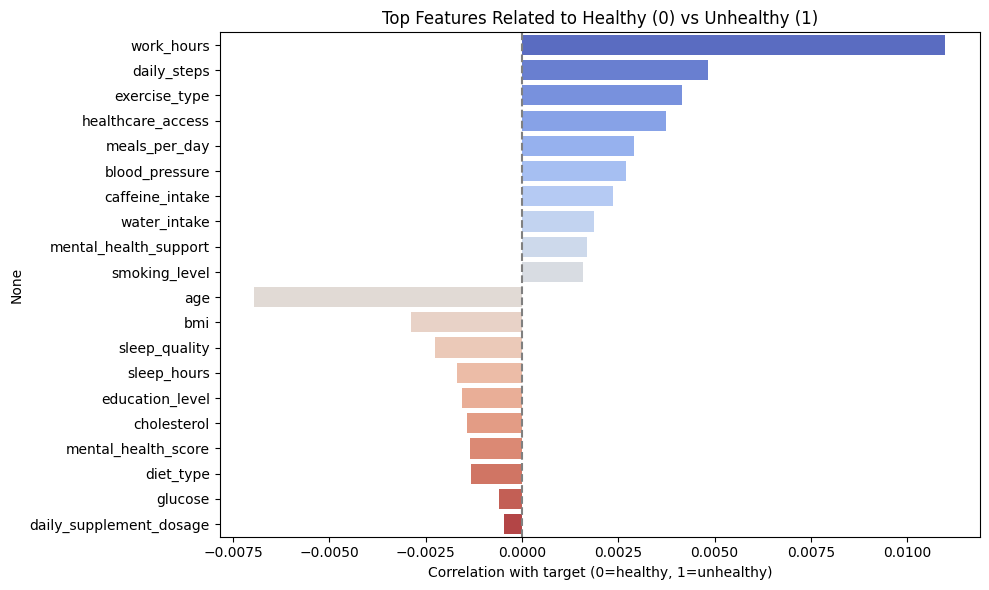

Top correlations with Unhealthy (1):
 work_hours               0.010990
daily_steps              0.004821
exercise_type            0.004159
healthcare_access        0.003740
meals_per_day            0.002914
blood_pressure           0.002705
caffeine_intake          0.002355
water_intake             0.001869
mental_health_support    0.001678
smoking_level            0.001578
Name: target, dtype: float64

Top correlations with Healthy (0):
 age                       -0.006951
bmi                       -0.002884
sleep_quality             -0.002267
sleep_hours               -0.001685
education_level           -0.001553
cholesterol               -0.001435
mental_health_score       -0.001360
diet_type                 -0.001321
glucose                   -0.000589
daily_supplement_dosage   -0.000465
Name: target, dtype: float64


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select only numeric columns
numeric_df = df_tree.select_dtypes(include='number')

# Get correlation matrix
corr_matrix = numeric_df.corr()

# Correlation with target
target_corr = corr_matrix['target'].drop('target')

# Features positively correlated with unhealthy (target=1)
unhealthy_corr = target_corr.sort_values(ascending=False).head(10)

# Features positively correlated with healthy (target=0)
healthy_corr = target_corr.sort_values(ascending=True).head(10)

# Combine
combined_corr = pd.concat([
    unhealthy_corr.rename("Unhealthy (target=1)"),
    healthy_corr.rename("Healthy (target=0)")
])

# Plot side-by-side
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_corr.values, y=combined_corr.index, palette="coolwarm")
plt.title("Top Features Related to Healthy (0) vs Unhealthy (1)")
plt.xlabel("Correlation with target (0=healthy, 1=unhealthy)")
plt.axvline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()

# Print numeric values clearly
print("Top correlations with Unhealthy (1):\n", unhealthy_corr)
print("\nTop correlations with Healthy (0):\n", healthy_corr)

# Model Trainings and Accuracy Testing

## Logistic Regression Model

In [72]:
from sklearn.model_selection import train_test_split

X = df_tree.drop(columns=["target"])
y = df_tree["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Target distribution in train:", y_train.value_counts(normalize=True))

Train shape: (80000, 30) Test shape: (20000, 30)
Target distribution in train: target
1    0.700975
0    0.299025
Name: proportion, dtype: float64


In [70]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Example pipeline with imputation + scaling + logistic regression
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),   # or "median", "most_frequent"
    ("scaler", StandardScaler()),
    ("log_reg", LogisticRegression(max_iter=500, solver="liblinear"))
])

pipe.fit(X_train, y_train)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Healthcare'

In [71]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ValueError: could not convert string to float: 'Healthcare'

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500, solver="liblinear", class_weight=None)
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500, solver='liblinear')

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

NameError: name 'log_reg' is not defined

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(log_reg, X, y, cv=cv, scoring="roc_auc")

print("Cross-val ROC-AUC:", np.mean(scores), "±", np.std(scores))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.

Cross-val ROC-AUC: 0.5000728823461056 ± 0.0025145615210429226


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [74]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
proba = dummy.predict_proba(X_test)[:,1]
print("Dummy ROC-AUC:", roc_auc_score(y_test, proba))

Dummy ROC-AUC: 0.5


In [75]:
from sklearn.metrics import roc_auc_score
aucs = {}
for col in X_train.columns:
    try:
        aucs[col] = roc_auc_score(y_train, X_train[col])
    except: 
        continue
print(sorted(aucs.items(), key=lambda x: abs(x[1]-0.5), reverse=True)[:20])

[('work_hours', np.float64(0.507621354366681)), ('exercise_type', np.float64(0.5047355354967246)), ('age', np.float64(0.49573035341189464)), ('daily_steps', np.float64(0.5030006606435906)), ('bmi', np.float64(0.4970177486283922)), ('sleep_quality', np.float64(0.49718628485741156)), ('blood_pressure', np.float64(0.5025551198843607)), ('healthcare_access', np.float64(0.5023344557323934)), ('waist_size', np.float64(0.49782837008894765)), ('mental_health_score', np.float64(0.4979161208775221)), ('diet_type', np.float64(0.49808839956483386)), ('device_usage', np.float64(0.5018638072189148)), ('education_level', np.float64(0.49820286638447525)), ('sleep_hours', np.float64(0.49824711766454954)), ('cholesterol', np.float64(0.4985514886181903)), ('mental_health_support', np.float64(0.5014357584734406)), ('caffeine_intake', np.float64(0.5013373833672061)), ('water_intake', np.float64(0.5012769617302931)), ('daily_supplement_dosage', np.float64(0.5011129409760485)), ('stress_level', np.float64(0.

## Tree based

In [76]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, balanced_accuracy_score, classification_report,
    confusion_matrix
)

# Use df_tree_final (all numeric, target in {0,1})
TARGET_COL = "target"
X = df_tree.drop(columns=[TARGET_COL])
y = df_tree[TARGET_COL].astype(int)

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", y_train.value_counts(normalize=True).round(3).to_dict())
print("Test :", y_test.value_counts(normalize=True).round(3).to_dict())

# helper: scan thresholds and pick best
def tune_threshold(y_true, y_proba, metric="f1", grid=None):
    if grid is None:
        grid = np.linspace(0.05, 0.95, 37)
    best_thr, best_score = 0.5, -1
    for t in grid:
        y_pred = (y_proba >= t).astype(int)
        if metric == "f1":
            score = f1_score(y_true, y_pred, zero_division=0)
        elif metric == "balanced_accuracy":
            score = balanced_accuracy_score(y_true, y_pred)
        elif metric == "youden_j":
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            tpr = tp / (tp + fn + 1e-12)
            tnr = tn / (tn + fp + 1e-12)
            score = tpr + tnr - 1
        else:
            raise ValueError("metric must be 'f1', 'balanced_accuracy', or 'youden_j'")
        if score > best_score:
            best_score, best_thr = score, t
    return best_thr, best_score

def evaluate_at_threshold(y_true, y_proba, thr, title="Model"):
    y_pred = (y_proba >= thr).astype(int)
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    roc  = roc_auc_score(y_true, y_proba)

    print(f"\n=== {title} (thr={thr:.3f}) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=3, zero_division=0))

Train: {1: 0.701, 0: 0.299}
Test : {1: 0.701, 0: 0.299}


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    n_jobs=-1,
    class_weight="balanced",   # make it care about the minority class
    random_state=42
)

# small validation from train for threshold tuning
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

rf.fit(X_tr, y_tr)
val_proba = rf.predict_proba(X_val)[:, 1]
best_thr, _ = tune_threshold(y_val, val_proba, metric="balanced_accuracy")  # or "f1"

test_proba = rf.predict_proba(X_test)[:, 1]
evaluate_at_threshold(y_test, test_proba, thr=best_thr, title="RandomForest")


=== RandomForest (thr=0.725) ===
Accuracy : 0.4080
Precision: 0.6941
Recall   : 0.2779
F1-score : 0.3969
ROC-AUC  : 0.4942
Confusion matrix:
 [[ 4264  1717]
 [10123  3896]]

Classification report:
               precision    recall  f1-score   support

           0      0.296     0.713     0.419      5981
           1      0.694     0.278     0.397     14019

    accuracy                          0.408     20000
   macro avg      0.495     0.495     0.408     20000
weighted avg      0.575     0.408     0.403     20000



###  HistGradientBoosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

# weight positives more (compute scale w.r.t. train)
pos = (y_train == 1).sum(); neg = (y_train == 0).sum()
hgb = HistGradientBoostingClassifier(
    learning_rate=0.08,
    max_iter=500,
    class_weight={0: 1.0, 1: neg/max(pos,1)},   # similar to scale_pos_weight
    random_state=42
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

hgb.fit(X_tr, y_tr)
val_proba = hgb.predict_proba(X_val)[:, 1]
best_thr, _ = tune_threshold(y_val, val_proba, metric="balanced_accuracy")

test_proba = hgb.predict_proba(X_test)[:, 1]
evaluate_at_threshold(y_test, test_proba, thr=best_thr, title="HistGradientBoosting")


=== HistGradientBoosting (thr=0.475) ===
Accuracy : 0.6912
Precision: 0.7006
Recall   : 0.9769
F1-score : 0.8160
ROC-AUC  : 0.4987
Confusion matrix:
 [[  128  5853]
 [  324 13695]]

Classification report:
               precision    recall  f1-score   support

           0      0.283     0.021     0.040      5981
           1      0.701     0.977     0.816     14019

    accuracy                          0.691     20000
   macro avg      0.492     0.499     0.428     20000
weighted avg      0.576     0.691     0.584     20000



### XGBoost

1.	trains XGBoost and tunes the threshold
2.	computes SHAP on a sample
3.	builds shap_importance_df = mean(|SHAP|) per feature
4.	selects features with mean(|SHAP|) > 0.03 (with a fallback if too few)
5.	retrains on just those features, re-tunes the threshold, and evaluates

In [ ]:
from sklearn.metrics import (
    recall_score, precision_score, accuracy_score, confusion_matrix,
    classification_report
)
import numpy as np

def tune_threshold_for_recall0(y_true, proba1, *,
                               min_precision1=0.65,   # keep some precision on class 1
                               min_accuracy=None,     # or require min overall accuracy
                               grid=None):
    """
    Pick the threshold that maximizes recall for class 0 (specificity),
    while meeting optional constraints.
    """
    if grid is None:
        grid = np.linspace(0.05, 0.95, 181)

    best_thr, best_rec0 = 0.5, -1.0
    best_stats = {}
    for t in grid:
        y_pred = (proba1 >= t).astype(int)
        rec0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
        prec1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        acc   = accuracy_score(y_true, y_pred)
        ok = True
        if min_precision1 is not None:
            ok &= (prec1 >= min_precision1)
        if min_accuracy is not None:
            ok &= (acc >= min_accuracy)
        if ok and rec0 > best_rec0:
            best_rec0, best_thr = rec0, t
            best_stats = {"recall0": rec0, "precision1": prec1, "accuracy": acc}
    # fallback: no threshold met constraints → take highest recall0 regardless
    if best_rec0 < 0:
        for t in grid:
            y_pred = (proba1 >= t).astype(int)
            rec0 = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
            if rec0 > best_rec0:
                best_rec0, best_thr = rec0, t
                best_stats = {}
    return float(best_thr), best_stats

def evaluate_with_thr(y_true, proba1, thr, title="Model"):
    y_pred = (proba1 >= thr).astype(int)
    print(f"\n=== {title} (thr={thr:.3f}) ===")
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

In [ ]:
from sklearn.metrics import recall_score, fbeta_score

def predict_at_threshold(proba1, thr):
    return (proba1 >= thr).astype(int)

def best_thr_for_recall0(y_true, proba1, n_steps=199):
    thrs = np.linspace(0.01, 0.99, n_steps)
    best_thr, best = 0.5, -1.0
    for t in thrs:
        rec0 = recall_score(y_true, predict_at_threshold(proba1, t), pos_label=0)
        if rec0 > best:
            best_thr, best = t, rec0
    return best_thr, best

def make_sample_weight(y, boost=1.0):
    y = np.asarray(y)
    n0 = (y==0).sum(); n1 = (y==1).sum()
    if n0==0 or n1==0: return np.ones_like(y, float)
    w0 = (n1/n0) * boost        # upweight class 0
    return np.where(y==0, w0, 1.0).astype(float)

In [ ]:
from xgboost import XGBClassifier
import shap

# --- 1) Train base XGB and tune threshold on validation
xgb = XGBClassifier(
    tree_method="hist",            
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)
# before: xgb.fit(X_tr, y_tr)
sw_tr = make_sample_weight(y_tr, boost=1.5)   # try 1.5–2.0
xgb.fit(X_tr, y_tr, sample_weight=sw_tr)

val_proba = xgb.predict_proba(X_val)[:, 1]
best_thr, _ = tune_threshold(y_val, val_proba, metric="balanced_accuracy")

test_proba = xgb.predict_proba(X_test)[:, 1]
evaluate_at_threshold(y_test, test_proba, thr=best_thr, title="XGBoost (all features)")

# --- 2) SHAP on a sample and build shap_importance_df
n_sample = min(1000, len(X_test))        # keep it brisk; 
X_shap = X_test.sample(n_sample, random_state=42)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap, check_additivity=False)  # (n_rows, n_features)

mean_abs = np.abs(shap_values).mean(axis=0)         # mean |SHAP| per feature
shap_importance_df = (pd.DataFrame({
    "Feature": X_shap.columns,
    "mean(|SHAP|)": mean_abs
}).sort_values("mean(|SHAP|)", ascending=False))

print("\nTop SHAP features (global mean |SHAP|):")
print(shap_importance_df.head(15).to_string(index=False))

# Optional: quick global bar
shap.summary_plot(shap_values, X_shap, plot_type="bar")

# --- 3) Select features with mean(|SHAP|) > 0.03 (fallback to top 10 if too few)
THRESH = 0.03
sel_feats = list(shap_importance_df.loc[shap_importance_df["mean(|SHAP|)"] > THRESH, "Feature"])

if len(sel_feats) < 3:  # fallback so we don't end up with too tiny a set
    sel_feats = list(shap_importance_df.head(10)["Feature"])
    print(f"\n[Fallback] Fewer than 3 features above {THRESH}; using top 10 by SHAP instead.")
else:
    print(f"\nSelected {len(sel_feats)} features with mean(|SHAP|) > {THRESH}:")
    print(sel_feats)

# --- 4) Retrain using only the selected features
X_train_sel = X_train[sel_feats].copy()
X_test_sel  = X_test[sel_feats].copy()

X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train_sel, y_train, test_size=0.2, random_state=123, stratify=y_train
)

xgb_red = XGBClassifier(
    tree_method="hist",
    n_estimators=400, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, use_label_encoder=False, eval_metric="logloss"
)
# before: xgb_red.fit(X_tr2, y_tr2)
sw_tr2 = make_sample_weight(y_tr2, boost=1.5) # same boost here
xgb_red.fit(X_tr2, y_tr2, sample_weight=sw_tr2)

val_proba2 = xgb_red.predict_proba(X_val2)[:, 1]
thr_r0_2, stats2 = tune_threshold_for_recall0(
    y_val2, val_proba2,
    min_precision1=0.70,   
    min_accuracy=0.69
)
print("Chosen thr (reduced):", thr_r0_2)
print(stats2)

test_proba2 = xgb_red.predict_proba(X_test_sel)[:, 1]
evaluate_with_thr(y_test, test_proba2, thr_r0_2, title="XGB (reduced) – recall0-optimized")

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

###  LightGBM

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight="balanced",
    random_state=42
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

lgbm.fit(X_tr, y_tr)
val_proba = lgbm.predict_proba(X_val)[:, 1]
best_thr, _ = tune_threshold(y_val, val_proba, metric="balanced_accuracy")

test_proba = lgbm.predict_proba(X_test)[:, 1]
evaluate_at_threshold(y_test, test_proba, thr=best_thr, title="LightGBM")

[LightGBM] [Info] Number of positive: 44862, number of negative: 19138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4207
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

=== LightGBM (thr=0.500) ===
Accuracy : 0.5572
Precision: 0.7004
Recall   : 0.6436
F1-score : 0.6708
ROC-AUC  : 0.4984
Confusion matrix:
 [[2121 3860]
 [4997 9022]]

Classification report:
               precision    recall  f1-score   support

           0      0.298     0.355     0.324      5981
           1      0.700     0.644     0.671     14019

    accuracy                          0.557     20000
   macro avg      0.499     0.499

### CatBoost

In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(
    iterations=600,
    depth=6,
    learning_rate=0.05,
    auto_class_weights="Balanced",  # handles imbalance internally
    verbose=0,
    random_state=42
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

cat.fit(X_tr, y_tr)
val_proba = cat.predict_proba(X_val)[:, 1]
best_thr, _ = tune_threshold(y_val, val_proba, metric="balanced_accuracy")

test_proba = cat.predict_proba(X_test)[:, 1]
evaluate_at_threshold(y_test, test_proba, thr=best_thr, title="CatBoost")


=== CatBoost (thr=0.500) ===
Accuracy : 0.5378
Precision: 0.7012
Recall   : 0.5936
F1-score : 0.6429
ROC-AUC  : 0.5004
Confusion matrix:
 [[2434 3547]
 [5697 8322]]

Classification report:
               precision    recall  f1-score   support

           0      0.299     0.407     0.345      5981
           1      0.701     0.594     0.643     14019

    accuracy                          0.538     20000
   macro avg      0.500     0.500     0.494     20000
weighted avg      0.581     0.538     0.554     20000



### Tree Based Models Testing  - Training models Based on Top Influential Features Extraction - Other than SHAP

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, balanced_accuracy_score
)

def metrics_at_threshold(y_true, y_proba, thr: float):
    y_pred = (y_proba >= thr).astype(int)

    # per-class precision (order: [0, 1])
    prec_per_class = precision_score(
        y_true, y_pred, average=None, labels=[0, 1], zero_division=0
    )

    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "precision_0": float(prec_per_class[0]),
        "precision_1": float(prec_per_class[1]),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "y_pred": y_pred,
    }

In [ ]:
from sklearn.inspection import permutation_importance

def model_importance_df(model, X, y=None):
    # CatBoost native
    try:
        from catboost import CatBoostClassifier, Pool
        if isinstance(model, CatBoostClassifier):
            imp = model.get_feature_importance(Pool(X, y), type="FeatureImportance")
            return (pd.DataFrame({"Feature": X.columns, "importance": imp})
                    .sort_values("importance", ascending=False))
    except Exception:
        pass

    # Tree models with .feature_importances_
    if hasattr(model, "feature_importances_"):
        return (pd.DataFrame({"Feature": X.columns, "importance": model.feature_importances_})
                .sort_values("importance", ascending=False))

    # Fallback: permutation importance (fast sample)
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X), size=min(2000, len(X)), replace=False)
    Xs, ys = X.iloc[idx], (y.iloc[idx] if y is not None else None)
    perm = permutation_importance(model, Xs, ys, n_repeats=5, random_state=42, n_jobs=-1)
    return (pd.DataFrame({"Feature": X.columns, "importance": np.abs(perm.importances_mean)})
            .sort_values("importance", ascending=False))


def run_importance_reduction_with_metrics(
    base_model, name,
    X_train, y_train, X_test, y_test,
    top_k=12, importance_min=None,
    thr_metric="balanced_accuracy",
    print_top=12
):
    # ===== Baseline =====
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=123
    )
    model = base_model.__class__(**base_model.get_params())
    model.fit(X_tr, y_tr)

    val_proba = model.predict_proba(X_val)[:, 1]
    best_thr, _ = tune_threshold(y_val, val_proba, metric=thr_metric)

    test_proba = model.predict_proba(X_test)[:, 1]
    print(f"\n=== {name} (all features) (thr={best_thr:.3f}) ===")
    evaluate_at_threshold(y_test, test_proba, thr=best_thr, title=f"{name} (all features)")
    base_metrics = metrics_at_threshold(y_test, test_proba, best_thr)

    

    # ===== Importance & selection =====
    imp_df = model_importance_df(model, X_train, y_train)
    print("\nTop features by model importance:")
    print(imp_df.head(print_top).to_string(index=False))

    if importance_min is not None:
        imp_cut = imp_df[imp_df["importance"] >= importance_min]
        sel = imp_cut.head(top_k) if len(imp_cut) > 0 else imp_df.head(top_k)
    else:
        sel = imp_df.head(top_k)

    selected_feats = list(sel["Feature"])
    print(f"\nSelected {len(selected_feats)} features:\n{selected_feats}")

    # ===== Reduced =====
    X_train_sel = X_train[selected_feats].copy()
    X_test_sel  = X_test[selected_feats].copy()

    X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
        X_train_sel, y_train, test_size=0.2, stratify=y_train, random_state=123
    )
    model2 = base_model.__class__(**base_model.get_params())
    model2.fit(X_tr2, y_tr2)

    val_proba2 = model2.predict_proba(X_val2)[:, 1]
    best_thr2, best_score2 = tune_threshold(y_val2, val_proba2, metric=thr_metric)

    test_proba2 = model2.predict_proba(X_test_sel)[:, 1]
    print(f"\n=== {name} (top-{len(selected_feats)} feats) (thr={best_thr2:.3f}) ===")
    evaluate_at_threshold(y_test, test_proba2, thr=best_thr2, title=f"{name} (reduced)")
    red_metrics = metrics_at_threshold(y_test, test_proba2, best_thr2)

    return {
        "name": name,
        "baseline": base_metrics,
        "reduced": red_metrics,
        "selected_feats": selected_feats,
        "importance_table": imp_df
    }

In [ ]:
results = []

# Example models (add/remove as you like)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

xgb = XGBClassifier(
    tree_method="hist",
    n_estimators=400, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, use_label_encoder=False, eval_metric="logloss"
)
lgbm = LGBMClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=-1,
    subsample=0.8, colsample_bytree=0.8, random_state=42, is_unbalance=True
)
rf = RandomForestClassifier(
    n_estimators=400, class_weight="balanced", random_state=42, n_jobs=-1
)
hgb = HistGradientBoostingClassifier(learning_rate=0.1, max_bins=255, random_state=42)
dt = DecisionTreeClassifier(max_depth=6, class_weight="balanced", random_state=42)
cat = CatBoostClassifier(iterations=600, depth=6, learning_rate=0.05,
                         auto_class_weights="Balanced", verbose=0, random_state=42)

for model, name in [
    (xgb, "XGBoost"),
    (lgbm, "LightGBM"),
    (rf, "RandomForest"),
    (hgb, "HistGradientBoosting"),
    (dt, "DecisionTree"),
    (cat, "CatBoost"),
]:
    res = run_importance_reduction_with_metrics(
        model, name,
        X_train, y_train, X_test, y_test,
        top_k=12,              # keep top 12
        importance_min=None,   # or set a floor e.g. 0.002
        thr_metric="balanced_accuracy"
    )
    results.append(res)

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:04:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost (all features) (thr=0.700) ===

=== XGBoost (all features) (thr=0.700) ===
Accuracy : 0.5111
Precision: 0.6976
Recall   : 0.5341
F1-score : 0.6050
ROC-AUC  : 0.4964
Confusion matrix:
 [[2736 3245]
 [6532 7487]]

Classification report:
               precision    recall  f1-score   support

           0      0.295     0.457     0.359      5981
           1      0.698     0.534     0.605     14019

    accuracy                          0.511     20000
   macro avg      0.496     0.496     0.482     20000
weighted avg      0.577     0.511     0.531     20000


Top features by model importance:
                Feature  importance
           water_intake    0.034806
             heart_rate    0.034683
                glucose    0.034653
                    bmi    0.034571
            daily_steps    0.034525
         calorie_intake    0.034388
      physical_activity    0.034349
daily_supplement_dosage    0.034288
             waist_size    0.034174
         blood_pressure    0.

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:04:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost (top-12 feats) (thr=0.650) ===

=== XGBoost (reduced) (thr=0.650) ===
Accuracy : 0.6472
Precision: 0.7009
Recall   : 0.8665
F1-score : 0.7750
ROC-AUC  : 0.5026
Confusion matrix:
 [[  797  5184]
 [ 1871 12148]]

Classification report:
               precision    recall  f1-score   support

           0      0.299     0.133     0.184      5981
           1      0.701     0.867     0.775     14019

    accuracy                          0.647     20000
   macro avg      0.500     0.500     0.480     20000
weighted avg      0.581     0.647     0.598     20000

[LightGBM] [Info] Number of positive: 44862, number of negative: 19138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4207
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 30
[

KeyboardInterrupt: 


Model performance (baseline vs reduced):
               model  acc_baseline  acc_reduced  delta_acc  f1_baseline  f1_reduced  delta_f1  bal_acc_base  bal_acc_red  delta_bal  roc_base  roc_red  delta_roc
             XGBoost        0.5112       0.6472     0.1361       0.6050      0.7750    0.1700        0.4958       0.4999     0.0041    0.4964   0.5026     0.0062
            LightGBM        0.4804       0.5472     0.0668       0.5475      0.6561    0.1086        0.5018       0.5008    -0.0010    0.5012   0.5044     0.0032
        DecisionTree        0.4956       0.4972     0.0016       0.5775      0.5796    0.0021        0.4982       0.4991     0.0009    0.4983   0.5002     0.0019
        RandomForest        0.4080       0.4222     0.0142       0.3969      0.4265    0.0296        0.4954       0.4999     0.0044    0.4942   0.5013     0.0071
            CatBoost        0.5378       0.3250    -0.2128       0.6429      0.1246   -0.5183        0.5003       0.4972    -0.0030    0.5004   0.50

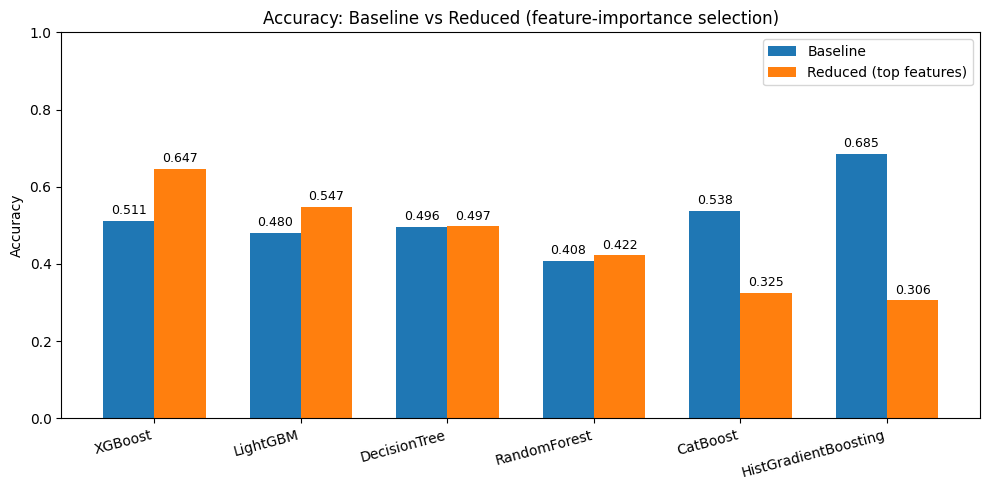


Deltas (reduced - baseline):
               model    Δacc     Δf1  ΔbalAcc    ΔROC
             XGBoost  0.1361  0.1700   0.0041  0.0062
            LightGBM  0.0668  0.1086  -0.0010  0.0032
        DecisionTree  0.0016  0.0021   0.0009  0.0019
        RandomForest  0.0142  0.0296   0.0044  0.0071
            CatBoost -0.2128 -0.5183  -0.0030  0.0030
HistGradientBoosting -0.3796 -0.7768  -0.0003 -0.0070


In [ ]:
import matplotlib.pyplot as plt

# Build a small table of metrics
rows = []
for r in results:
    rows.append({
        "model": r["name"],
        "acc_baseline": r["baseline"]["accuracy"],
        "acc_reduced":  r["reduced"]["accuracy"],
        "delta_acc":    r["reduced"]["accuracy"] - r["baseline"]["accuracy"],
        "f1_baseline":  r["baseline"]["f1"],
        "f1_reduced":   r["reduced"]["f1"],
        "delta_f1":     r["reduced"]["f1"] - r["baseline"]["f1"],
        "bal_acc_base": r["baseline"]["balanced_accuracy"],
        "bal_acc_red":  r["reduced"]["balanced_accuracy"],
        "delta_bal":    r["reduced"]["balanced_accuracy"] - r["baseline"]["balanced_accuracy"],
        "roc_base":     r["baseline"]["roc_auc"],
        "roc_red":      r["reduced"]["roc_auc"],
        "delta_roc":    r["reduced"]["roc_auc"] - r["baseline"]["roc_auc"],
    })
    
perf_df = pd.DataFrame(rows).sort_values("acc_reduced", ascending=False)
print("\nModel performance (baseline vs reduced):")
print(perf_df[["model","acc_baseline","acc_reduced","delta_acc",
               "f1_baseline","f1_reduced","delta_f1",
               "bal_acc_base","bal_acc_red","delta_bal",
               "roc_base","roc_red","delta_roc"]]
      .round(4).to_string(index=False))

# Bar plot: accuracy before/after
labels = perf_df["model"].values
x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(10,5))
b1 = ax.bar(x - w/2, perf_df["acc_baseline"].values, width=w, label="Baseline")
b2 = ax.bar(x + w/2, perf_df["acc_reduced"].values, width=w, label="Reduced (top features)")

ax.set_title("Accuracy: Baseline vs Reduced (feature-importance selection)")
ax.set_xticks(x, labels, rotation=15, ha="right")
ax.set_ylim(0, 1.0)
ax.set_ylabel("Accuracy")
ax.legend()

# annotate deltas above bars (reduced)
for xi, v in zip(x, perf_df["acc_reduced"].values):
    ax.text(xi + w/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

for xi, v in zip(x, perf_df["acc_baseline"].values):
    ax.text(xi - w/2, v + 0.01, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Quick textual summary of increases/decreases
delta_txt = (perf_df[["model","delta_acc","delta_f1","delta_bal","delta_roc"]]
             .round(4)
             .rename(columns={"delta_acc":"Δacc", "delta_f1":"Δf1", "delta_bal":"ΔbalAcc", "delta_roc":"ΔROC"}))
print("\nDeltas (reduced - baseline):")
print(delta_txt.to_string(index=False))

## Model Selection

### XG Boost

1.	trains XGBoost and tunes the threshold
2.	computes SHAP on a sample
3.	builds shap_importance_df = mean(|SHAP|) per feature
4.	selects features with mean(|SHAP|) > 0.03 (with a fallback if too few)
5.	retrains on just those features, re-tunes the threshold, and evaluates

In [80]:
from xgboost import XGBClassifier
import shap

# --- 1) Train base XGB and tune threshold on validation
xgb = XGBClassifier(
    tree_method="hist",            
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)
# before: xgb.fit(X_tr, y_tr)
sw_tr = make_sample_weight(y_tr, boost=1.5)   # try 1.5–2.0
xgb.fit(X_tr, y_tr, sample_weight=sw_tr)

val_proba = xgb.predict_proba(X_val)[:, 1]
best_thr, _ = tune_threshold(y_val, val_proba, metric="balanced_accuracy")

test_proba = xgb.predict_proba(X_test)[:, 1]
evaluate_at_threshold(y_test, test_proba, thr=best_thr, title="XGBoost (all features)")

# --- 2) SHAP on a sample and build shap_importance_df
n_sample = min(1000, len(X_test))        # keep it brisk; adjust if you want
X_shap = X_test.sample(n_sample, random_state=42)
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap, check_additivity=False)  # (n_rows, n_features)

mean_abs = np.abs(shap_values).mean(axis=0)         # mean |SHAP| per feature
shap_importance_df = (pd.DataFrame({
    "Feature": X_shap.columns,
    "mean(|SHAP|)": mean_abs
}).sort_values("mean(|SHAP|)", ascending=False))

print("\nTop SHAP features (global mean |SHAP|):")
print(shap_importance_df.head(15).to_string(index=False))

# Optional: quick global bar
shap.summary_plot(shap_values, X_shap, plot_type="bar")

# --- 3) Select features with mean(|SHAP|) > 0.03 (fallback to top 10 if too few)
THRESH = 0.03
sel_feats = list(shap_importance_df.loc[shap_importance_df["mean(|SHAP|)"] > THRESH, "Feature"])

if len(sel_feats) < 3:  # fallback so we don't end up with too tiny a set
    sel_feats = list(shap_importance_df.head(10)["Feature"])
    print(f"\n[Fallback] Fewer than 3 features above {THRESH}; using top 10 by SHAP instead.")
else:
    print(f"\nSelected {len(sel_feats)} features with mean(|SHAP|) > {THRESH}:")
    print(sel_feats)

# --- 4) Retrain using only the selected features
X_train_sel = X_train[sel_feats].copy()
X_test_sel  = X_test[sel_feats].copy()

X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train_sel, y_train, test_size=0.2, random_state=123, stratify=y_train
)

xgb_red = XGBClassifier(
    tree_method="hist",
    n_estimators=400, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, use_label_encoder=False, eval_metric="logloss"
)
# before: xgb_red.fit(X_tr2, y_tr2)
sw_tr2 = make_sample_weight(y_tr2, boost=1.5) # same boost here
xgb_red.fit(X_tr2, y_tr2, sample_weight=sw_tr2)

val_proba2 = xgb_red.predict_proba(X_val2)[:, 1]
thr_r0_2, stats2 = tune_threshold_for_recall0(
    y_val2, val_proba2,
    min_precision1=0.70,  
    min_accuracy=0.69
)
print("Chosen thr (reduced):", thr_r0_2)
print(stats2)

test_proba2 = xgb_red.predict_proba(X_test_sel)[:, 1]
evaluate_with_thr(y_test, test_proba2, thr_r0_2, title="XGB (reduced) – recall-optimized")

ImportError: Numba needs NumPy 2.0 or less. Got NumPy 2.2.

### Selecting model to dumbs

In [ ]:
import joblib

# Save model and selected features
joblib.dump(xgb_red, "xgb_model.pkl")
joblib.dump(sel_feats, "selected_features.pkl")
joblib.dump(thr_r0_2, "best_threshold.pkl")

['best_threshold.pkl']

### Exploring the final Selected Features for Frontend

In [ ]:
selected_feats = [
    "sugar_intake", "bmi", "cholesterol", "sleep_hours", 
    "physical_activity", "work_hours", "blood_pressure", 
    "calorie_intake", "water_intake", "daily_supplement_dosage", 
    "screen_time", "glucose", "insulin", "age", "daily_steps"
]

In [ ]:
# Keep only selected features + target
df_filtered = df_tree[selected_feats + ["target"]]

print("Filtered dataset shape:", df_filtered.shape)
print(df_filtered.head())

Filtered dataset shape: (100000, 16)
   sugar_intake        bmi  cholesterol  sleep_hours  physical_activity  \
0     44.476887  18.915925   214.580523     6.475885           0.356918   
1     74.663405  36.716278   115.794002     8.428410           0.568219   
2     19.702382  25.673050   138.134787     5.702164           3.764406   
3     82.580050  21.318480   203.017447     5.188316           0.889474   
4     45.961322  14.943302   200.412439     7.912514           2.901608   

   work_hours  blood_pressure  calorie_intake  water_intake  \
0    7.671313      118.264254     2673.546960      1.694262   
1    9.515198      117.917986     2650.376972      0.716409   
2    5.829853      123.073698     1746.755144      2.487900   
3    9.489693      148.173453     2034.193242      2.643335   
4    7.275450      150.613181     2386.210257      1.968393   

   daily_supplement_dosage  screen_time     glucose    insulin  age  \
0                -2.275502     5.003963  103.008176  14.987708

In [ ]:
df_decoded = df_tree.copy()

for col in cat_cols:
    if col in df_tree.columns:
        df_decoded[col] = df_tree[col].map(code_to_label[col])

In [ ]:
for col in cat_cols:
    if col in code_to_label:
        print(f"\n{col} mapping:")
        print(code_to_label[col])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Summary stats
print(df_filtered.describe().T)

# Histograms by target
for col in selected_feats:
    plt.figure(figsize=(6,3))
    sns.histplot(data=df_filtered, x=col, hue="target", kde=True, bins=30)
    plt.title(f"{col} distribution by target")
    plt.show()

# Finetuning Model

In [77]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# ============================================================
# 1) Train base XGB on ALL features and tune threshold on a val split
# ============================================================
xgb = XGBClassifier(
    tree_method="hist",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1,
)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123, stratify=y_train
)

xgb.fit(X_tr, y_tr)

val_proba = xgb.predict_proba(X_val)[:, 1]
best_thr_all, _ = tune_threshold(y_val, val_proba, metric="balanced_accuracy")

test_proba_all = xgb.predict_proba(X_test)[:, 1]
evaluate_at_threshold(y_test, test_proba_all, thr=best_thr_all, title="XGBoost (all features)")

# ============================================================
# 2) SHAP importances → feature list + tidy DataFrame
# ============================================================
n_sample = min(1000, len(X_test))  # speed-up for SHAP
X_shap = X_test.sample(n_sample, random_state=42)

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_shap, check_additivity=False)  # (n_rows, n_features)

shap_importance_df = (
    pd.DataFrame({
        "Feature": X_shap.columns,
        "mean(|SHAP|)": np.abs(shap_values).mean(axis=0)
    })
    .sort_values("mean(|SHAP|)", ascending=False)
    .reset_index(drop=True)
)

print("\nTop 15 by mean(|SHAP|):")
print(shap_importance_df.head(15).to_string(index=False))

# === Selection rule (edit here) ===
THRESH = 0.03
TOP_FALLBACK = 10
sel_feats = shap_importance_df.loc[shap_importance_df["mean(|SHAP|)"] > THRESH, "Feature"].tolist()
if len(sel_feats) < 3:
    sel_feats = shap_importance_df.head(TOP_FALLBACK)["Feature"].tolist()
    print(f"[Fallback] Using top {TOP_FALLBACK} features by SHAP since <3 passed THRESH={THRESH}")

# Optional: hard-override to try a custom subset (comment out if not needed)
# sel_feats = ['bmi', 'cholesterol', 'sleep_hours', 'daily_steps', 'sugar_intake']

# Keep a tidy record
selected_features_df = pd.DataFrame({"SelectedFeature": sel_feats})
print(f"\nSelected {len(sel_feats)} features:\n{sel_feats}")

# ============================================================
# 3) Build SEPARATE DataFrames for reduced feature training & testing
# ============================================================
X_train_sel = X_train[sel_feats].copy()
X_test_sel  = X_test[sel_feats].copy()


X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    X_train_sel, y_train, test_size=0.2, random_state=123, stratify=y_train
)


feature_store = {
    "all_features": list(X_train.columns),
    "selected_features": sel_feats,
    "shap_importance_df": shap_importance_df
}

# ============================================================
# 4) Train the REDUCED XGBoost model (only selected features)
# ============================================================
xgb_red = XGBClassifier(
    tree_method="hist",
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    n_jobs=-1,
)
xgb_red.fit(X_tr2, y_tr2)

val_proba2 = xgb_red.predict_proba(X_val2)[:, 1]
best_thr2, best_score2 = tune_threshold(y_val2, val_proba2, metric="balanced_accuracy")
print(f"\n[Reduced] Best threshold: {best_thr2:.3f} (bal-acc={best_score2:.4f})")

test_proba2 = xgb_red.predict_proba(X_test_sel)[:, 1]
evaluate_at_threshold(y_test, test_proba2, thr=best_thr2, title=f"XGBoost (reduced: {len(sel_feats)} feats)")

# ============================================================
# 5) (Optional) Quick fine-tuning on REDUCED features
#    → swap xgb_red with best estimator if it improves val metric
# ============================================================
param_dist = {
    "n_estimators": [200, 300, 400, 600, 800],
    "learning_rate": [0.03, 0.05, 0.07, 0.1],
    "max_depth": [3, 4, 5, 6, 7],
    "min_child_weight": [1, 2, 3, 5],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.5, 1.0],
    "reg_alpha": [0, 0.001, 0.01, 0.1],
    "reg_lambda": [0.5, 1.0, 1.5, 2.0],
}

xgb_base = XGBClassifier(
    tree_method="hist",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
)

search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring="balanced_accuracy",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)
search.fit(X_tr2, y_tr2)

# Evaluate the tuned candidate on the same val split + threshold tuning
xgb_tuned = search.best_estimator_
val_proba_tuned = xgb_tuned.predict_proba(X_val2)[:, 1]
best_thr_tuned, best_score_tuned = tune_threshold(y_val2, val_proba_tuned, metric="balanced_accuracy")
print(f"[Tuned] val bal-acc={best_score_tuned:.4f} @ thr={best_thr_tuned:.3f}")
print("Best params:", search.best_params_)

# If tuned is better, use it going forward:
use_tuned = best_score_tuned > best_score2
final_model = xgb_tuned if use_tuned else xgb_red
final_thr = best_thr_tuned if use_tuned else best_thr2

test_proba_final = final_model.predict_proba(X_test_sel)[:, 1]
evaluate_at_threshold(y_test, test_proba_final, thr=final_thr, title="XGBoost (FINAL reduced)")

NameError: name 'XGBClassifier' is not defined

Compute univariate AUC for each feature (does any single feature separate 0 vs 1?).
If all features are ≈0.5 → dataset has no predictive signal.

In [ ]:
from sklearn.metrics import roc_auc_score
aucs = {}
for col in X_train.columns:
    try:
        aucs[col] = roc_auc_score(y_train, X_train[col])
    except: 
        continue
print(sorted(aucs.items(), key=lambda x: abs(x[1]-0.5), reverse=True)[:20])

# Feature Engineering

* New features like:
	*	Risk composites (metabolic_risk, cardio_risk, obesity_flag)
	*	Lifestyle indices (sleep_efficiency, work_life_balance, stress_sleep_gap, activity_ratio)
	*	Likert transforms (stress_cat, mental_cat)
	*	Critical interactions (high_stress_low_support)
	*	Ratios (waist_height_ratio, sugar_ratio, water_per_weight, energy_balance)
* A table of top 20 features ranked by univariate ROC-AUC.
* If there are some engineered features jump to 0.55–0.65+, there is then some predictive signal.

In [ ]:
# ---------------------------
# 1. Copy original dataframe
# ---------------------------
df_eng = df_tree.copy()

# Ensure target is binary numeric
df_eng["target"] = df_eng["target"]

# ===========================
# 2. Feature Engineering
# ===========================

# --- Health Risk Scores ---
df_eng["metabolic_risk"] = (
    df_eng["bmi"] +
    df_eng["waist_size"]/100 +
    df_eng["cholesterol"]/200 +
    df_eng["glucose"]/100 +
    df_eng["blood_pressure"]/120 +
    df_eng["insulin"]/10
)

df_eng["cardio_risk"] = df_eng["blood_pressure"] * df_eng["cholesterol"] / (df_eng["heart_rate"] + 1)

df_eng["obesity_flag"] = ((df_eng["bmi"] >= 30) | (df_eng["waist_size"] > 100)).astype(int)

# --- Behavioral / Lifestyle ---
df_eng["sleep_efficiency"] = df_eng["sleep_quality"].map({
    "Poor": 1, "Fair": 2, "Good": 3, "Excellent": 4
}) * df_eng["sleep_hours"]

df_eng["work_life_balance"] = df_eng["work_hours"] / (
    df_eng["sleep_hours"] + df_eng["physical_activity"] + (df_eng["daily_steps"]/1000) + 1e-6
)

df_eng["stress_sleep_gap"] = df_eng["stress_level"] - df_eng["sleep_hours"]

df_eng["activity_ratio"] = df_eng["daily_steps"] / (df_eng["work_hours"] + 1)

# --- Likert transforms ---
df_eng["stress_cat"] = pd.cut(
    df_eng["stress_level"], bins=[-1,3,6,10], labels=["low","moderate","high"]
)
df_eng["mental_cat"] = pd.cut(
    df_eng["mental_health_score"], bins=[-1,4,7,10], labels=["poor","average","good"]
)

# Interaction: high stress with no support
df_eng["high_stress_low_support"] = (
    (df_eng["stress_level"] >= 7) & (df_eng["mental_health_support"] == "No")
).astype(int)

# --- Ratios ---
df_eng["waist_height_ratio"] = df_eng["waist_size"] / (df_eng["height"]+1e-6) if "height" in df_eng.columns else df_eng["waist_size"]/df_eng["bmi"]

df_eng["sugar_ratio"] = df_eng["sugar_intake"] / (df_eng["calorie_intake"] + 1e-6)

df_eng["water_per_weight"] = df_eng["water_intake"] / (df_eng["weight"]+1e-6) if "weight" in df_eng.columns else df_eng["water_intake"]/(df_eng["bmi"]+1e-6)

df_eng["energy_balance"] = df_eng["calorie_intake"] / (df_eng["daily_steps"] + 1)


# ===========================
# 3. Univariate AUCs
# ===========================
y = df_eng["target"]
aucs = {}

for col in df_eng.columns:
    if col == "target":
        continue
    try:
        x = df_eng[col]
        # If categorical, convert to dummy and take mean prob
        if x.dtype == "O" or str(x.dtype).startswith("category"):
            x = pd.get_dummies(x, drop_first=True)
            score = roc_auc_score(y, x.mean(axis=1))
        else:
            score = roc_auc_score(y, x)
        aucs[col] = score
    except Exception:
        continue

aucs_sorted = sorted(aucs.items(), key=lambda x: abs(x[1]-0.5), reverse=True)

print("\n=== Top 20 Features by univariate AUC ===")
for feat, auc in aucs_sorted[:20]:
    print(f"{feat:25s} AUC={auc:.3f}")


=== Top 20 Features by univariate AUC ===
work_hours                AUC=0.507
age                       AUC=0.496
work_life_balance         AUC=0.504
daily_steps               AUC=0.503
bmi                       AUC=0.497
metabolic_risk            AUC=0.497
exercise_type             AUC=0.503
healthcare_access         AUC=0.502
job_type                  AUC=0.498
waist_height_ratio        AUC=0.502
water_intake              AUC=0.502
blood_pressure            AUC=0.502
water_per_weight          AUC=0.502
meals_per_day             AUC=0.502
energy_balance            AUC=0.498
activity_ratio            AUC=0.498
sleep_hours               AUC=0.499
caffeine_intake           AUC=0.501
sleep_quality             AUC=0.499
mental_cat                AUC=0.499


1.	The dataset has almost no discriminative power in its current form.
	*	Even combinations like BMI + glucose + cholesterol (metabolic risk) are ≈ random.
	*	This suggests the target (healthy vs diseased) is not directly explained by these measurements.
2.	Possible issues:
	*	Label noise: Are the “diseased” vs “healthy” labels generated synthetically or misaligned?
	*	Feature leakage gap: Maybe the true predictors (e.g., diagnosis results, medications, hospital visits) aren’t in the dataset.
	*	Scaling/coding issues: Likert and categorical encodings might be reducing signal if not mapped correctly.
	*	Too balanced distributions: From the current histograms, most features are centered with normal-like distributions → little separation between groups.

### A dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
proba = dummy.predict_proba(X_test)[:,1]
print("Dummy ROC-AUC:", roc_auc_score(y_test, proba))

Dummy ROC-AUC: 0.5


### Stratify features by target

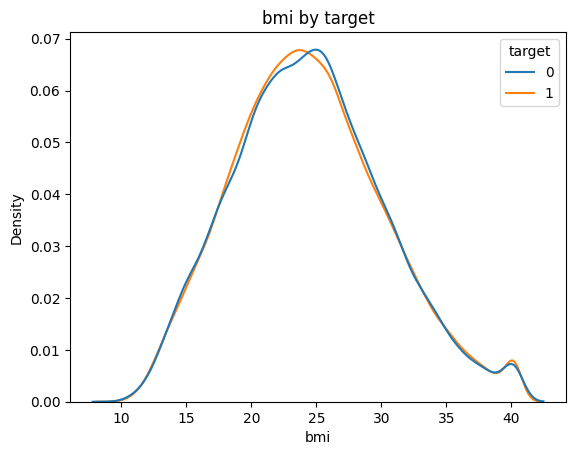

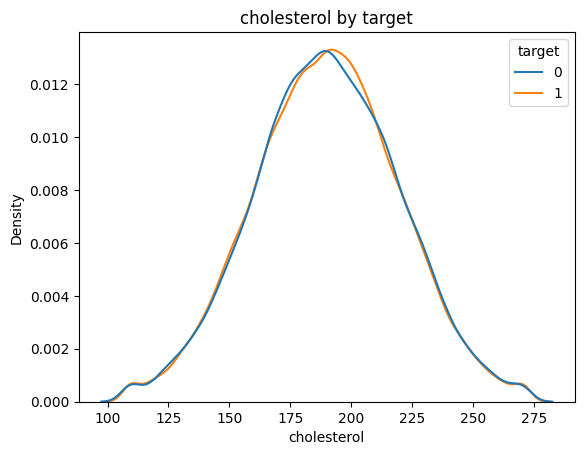

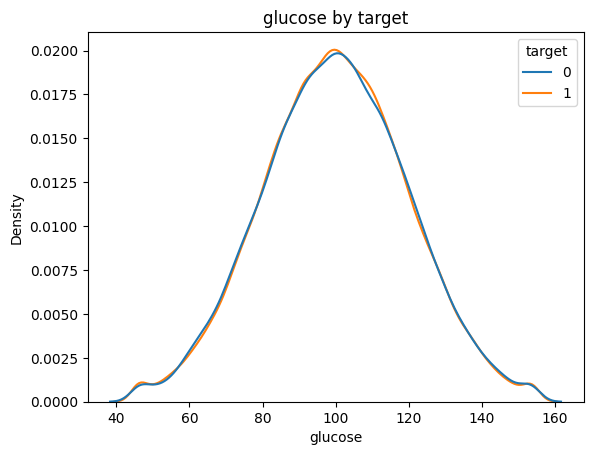

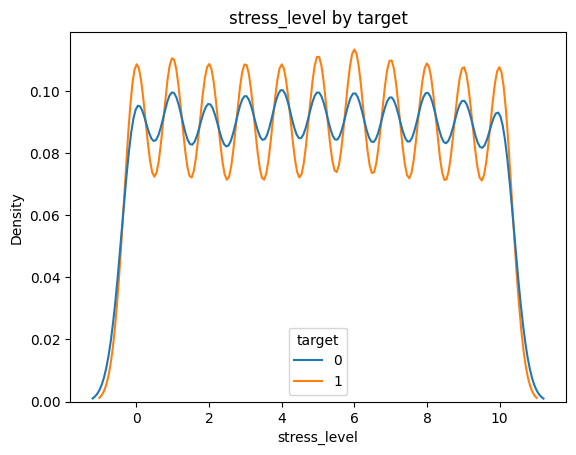

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ["bmi", "cholesterol", "glucose", "stress_level"]:
    sns.kdeplot(data=df_eng, x=col, hue="target", common_norm=False)
    plt.title(f"{col} by target")
    plt.show()

## Adding Polynomial Interactions

* Why this helps
	*	Instead of looking at each variable in isolation, this will automatically generate feature × feature interactions (e.g., bmi * glucose, stress * sleep, cholesterol * activity).
	*	Logistic regression (linear on these expanded features) can now pick up nonlinear decision boundaries.
	*	If disease risk emerges only when two conditions coincide (like high BMI + high cholesterol), we will finally see separation.

In [ ]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# --------------------------
# 1. Select numeric features
# --------------------------
num_cols = ['age', 'bmi', 'waist_size', 'blood_pressure', 
            'heart_rate', 'cholesterol', 'glucose', 'insulin', 
            'sleep_hours', 'work_hours', 'physical_activity', 
            'daily_steps', 'calorie_intake', 'sugar_intake', 
            'water_intake', 'screen_time', 'stress_level', 
            'mental_health_score', 'meals_per_day', 
            'daily_supplement_dosage']

X = df_eng[num_cols]
y = df_eng["target"]

# --------------------------
# 2. Train-test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --------------------------
# 3. Pipeline with poly features
# --------------------------
pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=5000, class_weight="balanced"))
])

pipe.fit(X_train, y_train)

# --------------------------
# 4. Evaluate
# --------------------------
proba = pipe.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, proba)
print("ROC-AUC with polynomial interactions:", auc)

ROC-AUC with polynomial interactions: 0.5005170747860891


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1.	builds pairwise interaction features for numeric columns,
2.	one-hot encodes categoricals,
3.	selects the Top-K features by mutual information (fast + model-agnostic), and
4.	trains XGBoost on the reduced matrix, picking a threshold that maximizes balanced accuracy.

In [ ]:
# ============================================================
# 0) Imports
# ============================================================

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import mutual_info_classif


# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def threshold_at_max_balacc(y_true, proba, grid_size=500):
    thr_grid = np.linspace(0.01, 0.99, grid_size)
    best_thr, best_balacc = 0.5, -1.0
    for t in thr_grid:
        y_hat = (proba >= t).astype(int)
        bal = balanced_accuracy_score(y_true, y_hat)
        if bal > best_balacc:
            best_balacc, best_thr = bal, t
    return float(best_thr), float(best_balacc)

def evaluate_all(y_true, proba, thr, title="Model"):
    y_pred = (proba >= thr).astype(int)
    acc  = (y_pred == y_true).mean()
    prec = ((y_pred==1) & (y_true==1)).sum() / max((y_pred==1).sum(), 1)
    rec  = ((y_pred==1) & (y_true==1)).sum() / max((y_true==1).sum(), 1)
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    roc  = roc_auc_score(y_true, proba)
    pr   = average_precision_score(y_true, proba)
    cm   = confusion_matrix(y_true, y_pred)
    print(f"\n=== {title} (thr={thr:.3f}) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}")
    print(f"PR-AUC   : {pr:.4f}")
    print("Confusion matrix:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))

# ============================================================
# 1) Inputs: column lists 
# ============================================================
cat_cols = ['sleep_quality','smoking_level','mental_health_support',
            'education_level','job_type','diet_type','exercise_type','device_usage',
            'healthcare_access', 'caffeine_intake']

num_cols = ['age', 'bmi', 'waist_size', 'blood_pressure', 
            'heart_rate', 'cholesterol', 'glucose', 'insulin', 
            'sleep_hours', 'work_hours', 'physical_activity', 
            'daily_steps', 'calorie_intake', 'sugar_intake', 
            'water_intake', 'screen_time', 'stress_level', 
            'mental_health_score', 'meals_per_day', 
            'daily_supplement_dosage']
# ============================================================
# 2) Prepare data
# ============================================================
df = df_tree.copy()

TARGET_COL = "target"
X = df_tree.drop(columns=[TARGET_COL])
y = df['target'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# 3) Preprocess:
#    - OneHot for categoricals
#    - Numeric passthrough
#    - Numeric pairwise interactions (degree=2, interaction_only=True)
#    Output is a single sparse matrix with feature names
# ============================================================
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Two separate transforms on the SAME numeric block:
pre = ColumnTransformer(
    transformers=[
        ("cat_ohe", ohe, cat_cols),
        ("num_pass", "passthrough", num_cols),
        ("num_inter", poly, num_cols),
    ],
    remainder='drop',
    sparse_threshold=1.0,  # keep sparse for memory
)

# Fit on train only
pre.fit(X_train)

# Transform to sparse matrices
Xtr = pre.transform(X_train)   # scipy.sparse
Xte = pre.transform(X_test)

# Build feature names to align with mutual_info selection
cat_names = pre.named_transformers_['cat_ohe'].get_feature_names_out(cat_cols)
num_pass_names = np.array(num_cols)
# names for interactions:
poly_names_raw = pre.named_transformers_['num_inter'].get_feature_names_out(num_cols)
# Remove any duplicates with passthrough (shouldn’t happen with interaction_only=True)
feat_names = np.concatenate([cat_names, num_pass_names, poly_names_raw])

assert Xtr.shape[1] == len(feat_names)

# ============================================================
# 4) Mutual Information feature selection (fast, model-agnostic)
#    - Compute MI on a stratified sample to avoid dense conversion blow-up
# ============================================================
rng = np.random.RandomState(42)
sample_idx = rng.choice(Xtr.shape[0], size=min(30000, Xtr.shape[0]), replace=False)
Xtr_s = Xtr[sample_idx]
ytr_s = y_train.iloc[sample_idx].values

# mutual_info_classif requires dense; convert ONLY for the sample.

Xtr_s_dense = Xtr_s.toarray()

# Discrete mask: OneHot columns are discrete; numeric & interactions are continuous
n_cat = len(cat_names)
n_num = len(num_pass_names)
n_int = len(poly_names_raw)
discrete_mask = np.zeros(Xtr_s_dense.shape[1], dtype=bool)
discrete_mask[:n_cat] = True  # one-hots

mi = mutual_info_classif(Xtr_s_dense, ytr_s, discrete_features=discrete_mask, random_state=42)

# Pick Top-K by MI
K = 150  # adjust (100–300 is typical); 
topk_idx = np.argpartition(mi, -K)[-K:]
topk_idx = topk_idx[np.argsort(mi[topk_idx])[::-1]]  # sort descending
topk_names = feat_names[topk_idx]

print(f"\n[MI] Selected Top-{K} features.")
print(topk_names[:25])  # peek first 25

# Reduce train/test to selected columns
Xtr_sel = Xtr[:, topk_idx]
Xte_sel = Xte[:, topk_idx]

# ============================================================
# 5) Train XGBoost on the MI-reduced matrix
#    - handle class imbalance via scale_pos_weight
# ============================================================
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = neg / max(pos, 1)

xgb = XGBClassifier(
    tree_method="hist",
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=2,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.01,
    reg_lambda=1.5,
    random_state=42,
    eval_metric="logloss",
    n_jobs=-1,
    scale_pos_weight=spw,
)

xgb.fit(Xtr_sel, y_train)

# ============================================================
# 6) Threshold by MAX balanced accuracy on a small holdout from train
# ============================================================
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(
    Xtr_sel, y_train, test_size=0.2, random_state=123, stratify=y_train
)
xgb.fit(X_tr2, y_tr2)





[MI] Selected Top-150 features.
['waist_size sugar_intake' 'meals_per_day' 'waist_size cholesterol'
 'mental_health_score daily_supplement_dosage' 'bmi screen_time'
 'daily_steps calorie_intake' 'screen_time mental_health_score'
 'cholesterol sugar_intake' 'cholesterol daily_steps'
 'stress_level mental_health_score' 'age sugar_intake' 'screen_time'
 'daily_steps stress_level' 'age mental_health_score' 'screen_time' 'age'
 'physical_activity sugar_intake' 'insulin calorie_intake'
 'cholesterol insulin' 'glucose daily_steps' 'age water_intake'
 'heart_rate sugar_intake' 'age bmi' 'bmi calorie_intake' 'daily_steps']


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
val_proba = xgb.predict_proba(X_val2)[:, 1]
best_thr2, best_score2 = tune_threshold(y_val2, val_proba, metric="balanced_accuracy")
print(f"\nBest thr on SHAP-filtered set: {best_thr2:.3f} (bal-acc={best_score2:.4f})")

test_proba = xgb.predict_proba(Xte_sel)[:, 1]
evaluate_at_threshold(y_test, test_proba2, thr=best_thr2, title=f"XGBoost (SHAP>{THRESH} features)")


Best thr on SHAP-filtered set: 0.500 (bal-acc=0.5083)

=== XGBoost (SHAP>0.03 features) (thr=0.500) ===
Accuracy : 0.6996
Precision: 0.7008
Recall   : 0.9973
F1-score : 0.8232
ROC-AUC  : 0.4975
Confusion matrix:
 [[   12  5969]
 [   38 13981]]

Classification report:
               precision    recall  f1-score   support

           0      0.240     0.002     0.004      5981
           1      0.701     0.997     0.823     14019

    accuracy                          0.700     20000
   macro avg      0.470     0.500     0.414     20000
weighted avg      0.563     0.700     0.578     20000



In [ ]:
val_proba = xgb.predict_proba(X_val2)[:, 1]
thr_bal, bal_val = threshold_at_max_balacc(y_val2, val_proba)
print(f"\n[Threshold] Val best balanced accuracy = {bal_val:.4f} @ thr = {thr_bal:.3f}")

test_proba = xgb.predict_proba(Xte_sel)[:, 1]
evaluate_with_thr(y_test, test_proba2, thr_r0_2, title=f"XGB + Poly Interactions + MI Top-{K}")


[Threshold] Val best balanced accuracy = 0.5093 @ thr = 0.495

=== XGB + Poly Interactions + MI Top-150 (thr=0.320) ===
Confusion matrix:
 [[    0  5981]
 [    0 14019]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000      5981
           1      0.701     1.000     0.824     14019

    accuracy                          0.701     20000
   macro avg      0.350     0.500     0.412     20000
weighted avg      0.491     0.701     0.578     20000

